# Psychological Drivers of Climate Communication: A Supervised Learning Study

Data Scientist: Maximilian Thiel <br>
Company: GreenVoice Alliance <br>
Date: 30.06.2025 

- **Sources**:
    - Lectures and corresponding notebooks of MADS-ML 
    - Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: a guide for data scientists.
    - James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). An Introduction to Statistical Learning with Applications in Python.
    - Molnar, C. Interpretable Machine Learning: A Guide for Making Black Box Models Explainable
    - The sklearn documentations and User Guide 
    - Some code was adapted from websites like Stack Overflow but will be cited.

In [381]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, make_scorer,  RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RepeatedStratifiedKFold
import time
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.inspection import permutation_importance



## Task 1: Context

### The Scenario

* In this project, I take on the role of a data scientist working with an international NGO focused on climate communication. 
* The organization wants to improve the outreach of its online campaigns by identifying individuals who are more likely to share climate-related posts on social media.
* Social media is central in shaping public opinion and spreading scientific knowledge about climate change.
* Sharing behavior serves as a proxy for digital climate engagement and peer-to-peer influence.
* I aim to develop a binary classification model that predicts with psychological features whether a person will share a climate-related social media post.
* I deliberately exclude demographic and country-level variables to focus on the psychological drivers of communicative behavior.
* Beyond prediction, the goal is to understand which psychological factors such as beliefs, knowledge, or identity are most influential.
* This can support climate campaigns by helping them strengthen specific psychological components through targeted messaging and interventions.

### The Value

* A well-performing model can help identify individuals who are likely to engage with and spread climate-related messages online.
* Campaigns can use these insights to target likely advocates, improving the efficiency of outreach efforts.
* Understanding which psychological factors predict sharing behavior supports the design of tailored communication strategies.
* The findings can inform educational or behavioral interventions aimed at strengthening key traits such as trust in science or environmental identity.
* The project contributes to a broader understanding of how psychological dispositions relate to digital climate engagement.
* By relying only on psychological variables, the model isolates individual-level explanatory power, offering a clean basis for interpretation.

### The Quality Criteria

* To evaluate the model, I will use two performance metrics that are well-suited for this task:
F1-score and ROC-AUC.
* F1-Score
    * The F1-score balances precision and recall (harmonic mean).
    * This is important in my case because both types of classification errors matter:
        * A false positive means targeting someone unlikely to share, wasting outreach effort.
        * A false negative means missing someone who would have shared and amplified the message.
    * Since both types of errors are relevant and the class distribution is relatively balanced, the F1 score provides a more meaningful performance measure than accuracy, which can be misleading in such contexts.
* ROC-AUC (Receiver Operating Characteristic – Area Under the Curve)
    * This metric reflects how well the model separates sharers from non-sharers across all classification thresholds.
    * Threshold-independent: evaluates model performance and summarizes the trade-off between sensitivity (true positive rate) and specificity (false positive rate) without being tied to one decision cutoff (unlike F1).
    * While F1 score focuses on hard decisions at a fixed point, ROC AUC provides a global picture of model quality across all tresholds, giving a broader evaluation.
* Together, these two metrics provide a solid foundation to assess both the classification quality at a fixed threshold (via F1) and the overall separability of classes (via ROC-AUC).

## Task 2: The Data

* The dataset was taken from the recently published study **"Machine learning identifies key individual and nation-level factors predicting climate-relevant beliefs and behaviors"** by Todorova et al. (2025).
* It is based on a large-scale, cross-national survey and is published under a Creative Commons Attribution 4.0 International License.
* For this project, I used the dataset with the target variable ccshare, which indicates whether a person would share a climate-related post on social media.
* The dataset contains responses from 3,557 individuals across 55 countries, and includes 19 features spanning psychological, demographic, and nation-level dimensions.

In [382]:
data_raw =  pd.read_csv("share.csv")

In [383]:
data_raw.shape

(3557, 22)

In [384]:
data_raw.head(5)

,govtrust,humanid,globalid,ownestim,gender,age,income,edu,ses,scicons,...,extmotiv,intmotiv,politics,cri_2020,co_emissions,gini,hdi,CountryCode,pcpid,ccshare
0,94.0,98.0,96.0,67.0,1.0,35.0,7.0,3.0,8.0,13.0,...,21.6,95.0,14.0,92.5,3.5346,27.6,0.745,1,2.0,1
1,50.0,81.0,76.0,50.0,1.0,23.0,4.0,2.0,7.0,49.0,...,50.0,53.0,50.0,92.5,3.5346,27.6,0.745,1,3.0,1
2,46.0,100.0,67.0,28.0,1.0,50.0,8.0,4.0,6.0,77.0,...,3.0,70.6,15.0,92.5,3.5346,27.6,0.745,1,4.0,1
3,10.0,80.0,74.0,4.0,1.0,35.0,6.0,3.0,5.0,41.0,...,26.4,82.0,46.0,92.5,3.5346,27.6,0.745,1,5.0,1
4,50.0,30.0,40.0,21.0,1.0,45.0,2.0,2.0,2.0,100.0,...,0.0,100.0,54.0,92.5,3.5346,27.6,0.745,1,6.0,1


### Target variable

* ccshare 
  * Indicates whether a person would share a climate-related post on their social media. 
    * “Did youknow that removing meat and dairy for only two out of three meals per day could decrease food-related carbon emissions by 60%? It is an easy way to fight #ClimateChange #ManyLabsClimate,  source: https://econ.st/3qjvOnn” 
  * Binary encoded:  
    * `0` = Yes, I am willing to share this information.
    * `1` = I am not willing to share this information.

### Features

- The dataset includes a wide range of features, including demographic and contextual variables.
- However, in accordance with the customer's request, only psychological features are considered for model development.

Demographic Predictors

| Feature    | Description                                                                 | Range / Format                       |
|------------|-----------------------------------------------------------------------------|--------------------------------------|
| age        | Self-reported age                                                           | Numeric (in years)                   |
| gender     | Gender identity                                                             | Categorical (4 options)              |
| edu        | Years of formal education completed                                         | Ordinal (4 levels: 0–6 to 17+)       |
| politics   | Political orientation (combined score for social and economic issues)       | 0–100 (higher = more conservative)   |
| income     | Yearly household income                                                     | Ordinal (8 steps + prefer not to say)|
| ses        | Subjective social status on a social ladder                                 | 1–10                                 |

Psychological Predictors

| Feature     | Description                                                                 | Range / Format            |
|-------------|------------------------------------------------------------------------------|---------------------------|
| trustsci    | Trust in climate science (2-item scale, α = .91)                            | 0–100 (slider)            |
| govtrust    | Trust in government                                                         | 0–100 (slider)            |
| envid       | Environmentalist identity (4 items, α = .91)                                | 0–100 (slider)            |
| humanid     | Humanitarian identity                                                       | 0–100 (slider)            |
| globalid    | Global citizen identity                                                     | 0–100 (slider)            |
| intmotiv    | Environmental motivation – internal (5 items, α = .89)                      | 0–100 (slider)            |
| extmotiv    | Environmental motivation – external (5 items, α = .73)                      | 0–100 (slider)            |
| scicons     | Perceived scientific consensus on human-caused climate change              | 0–100 (%)                 |
| ownest      | Perceived percentage of people in own country who believe in climate crisis | 0–100 (%)                 |

Nation-Level Predictors

| Feature        | Description                                                              | Range / Format            |
|----------------|--------------------------------------------------------------------------|---------------------------|
| gini           | GINI coefficient (income inequality)                                     | Continuous (country-level)|
| hdi            | Human Development Index                                                  | Continuous (0–1 scale)    |
| cri_2020       | Climate Risk Index (higher = lower risk)                                 | Continuous (inverse scale)|
| co_emissions   | Per capita CO₂ emissions (tons, 2020)                                    | Continuous (country-level)|


### Suitability

* The dataset is well-suited for this project because it fulfills the formal requirements of the portfolio:
  * It is based on real-world, cross-national survey data from a peer-reviewed scientific study.
  * It is publicly available under a Creative Commons license (CC BY 4.0), ensuring legal reusability.

* From a methodological perspective, the dataset offers:
  * A binary classification target variable (ccshare), which is directly aligned with the project goal.
  * A sufficiently large number of observations (N = 3557), allowing for robust training and evaluation of machine learning models.
  * A balanced distribution of target classes, making standard classification metrics applicable without heavy adjustments for class imbalance.

* Substantively, the dataset supports a psychologically focused analysis:
  * It contains a rich set of individual-level psychological predictors that are theoretically relevant to climate-related communication behavior.
  * It allows me to focus the analysis on individual beliefs, identities, and motivations (excluding demographic and structural variables). Thus providing a clean framework to study psychological drivers of behavior.


## Task 3: Initial Data Analysis

This section provides an initial descriptive overview of the dataset to better understand the distribution and structure of the psychological features used in the modeling task.



In [385]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3557 entries, 0 to 3556
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   govtrust      3398 non-null   float64
 1   humanid       3552 non-null   float64
 2   globalid      3549 non-null   float64
 3   ownestim      3553 non-null   float64
 4   gender        3467 non-null   float64
 5   age           3509 non-null   float64
 6   income        3118 non-null   float64
 7   edu           3476 non-null   float64
 8   ses           3497 non-null   float64
 9   scicons       3494 non-null   float64
 10  trustsci      3419 non-null   float64
 11  envid         3554 non-null   float64
 12  extmotiv      3551 non-null   float64
 13  intmotiv      3552 non-null   float64
 14  politics      3186 non-null   float64
 15  cri_2020      3557 non-null   float64
 16  co_emissions  3557 non-null   float64
 17  gini          3557 non-null   float64
 18  hdi           3557 non-null 

### Compute percentage of missing values

In [386]:
print((data_raw.isnull().sum()/3557)*100)

govtrust         4.470059
humanid          0.140568
globalid         0.224909
ownestim         0.112454
gender           2.530222
age              1.349452
income          12.341861
edu              2.277200
ses              1.686815
scicons          1.771155
trustsci         3.879674
envid            0.084341
extmotiv         0.168681
intmotiv         0.140568
politics        10.430138
cri_2020         0.000000
co_emissions     0.000000
gini             0.000000
hdi              0.000000
CountryCode      0.000000
pcpid            0.927748
ccshare          0.000000
dtype: float64


* The dataset contains 3,557 observations and 22 variables.
* All variables are numeric, with no object/string types.
* The selected target variable `ccshare` is complete and contains no missing values.
* The predictors are mostly complete:
  * Missingness ranges between 0.1% and 12.3%.

In [387]:
data_raw.describe()

,govtrust,humanid,globalid,ownestim,gender,age,income,edu,ses,scicons,...,extmotiv,intmotiv,politics,cri_2020,co_emissions,gini,hdi,CountryCode,pcpid,ccshare
count,3398.000000,3552.000000,3549.000000,3553.000000,3467.000000,3509.000000,3118.000000,3476.000000,3497.000000,3494.000000,...,3551.000000,3552.000000,3186.000000,3557.000000,3557.000000,3557.000000,3557.000000,3557.000000,3524.000000,3557.000000
mean,45.601236,74.421171,68.859115,60.619758,1.536487,38.069820,4.249840,2.887802,5.859308,72.628220,...,36.183704,67.287683,53.071249,76.915328,6.934384,34.453753,0.852014,33.666854,2552.119183,0.465561
std,28.843424,20.772994,24.819833,22.158312,0.498739,15.037713,1.944727,0.662727,1.841765,20.975727,...,26.608531,20.479926,24.402919,33.250497,4.455512,6.648138,0.116832,19.353108,1472.290141,0.498883
min,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,17.670000,0.230000,23.200000,0.500000,1.000000,2.000000,0.000000
25%,20.000000,62.000000,53.000000,48.000000,1.000000,25.000000,3.000000,2.000000,5.000000,61.000000,...,13.600000,54.000000,39.000000,44.170000,3.731900,28.900000,0.795000,17.000000,1289.750000,0.000000
50%,49.000000,79.000000,72.000000,62.000000,2.000000,35.000000,4.000000,3.000000,6.000000,77.000000,...,32.200000,68.600000,52.500000,71.830000,6.510400,34.300000,0.911000,32.000000,2546.500000,0.000000
75%,70.000000,90.000000,89.000000,78.000000,2.000000,49.000000,5.000000,3.000000,7.000000,89.000000,...,55.200000,81.800000,70.000000,100.000000,8.149900,39.700000,0.929000,51.000000,3809.500000,1.000000
max,100.000000,100.000000,100.000000,100.000000,2.000000,81.000000,8.000000,4.000000,10.000000,100.000000,...,100.000000,100.000000,100.000000,158.330000,15.368400,63.000000,0.962000,63.000000,5041.000000,1.000000


### Investigate target variable

In [388]:
data_raw.ccshare.value_counts()

ccshare
0    1901
1    1656
Name: count, dtype: int64

* The target variable `ccshare` indicates willingness to share a climate-related post on social media.
* The distribution is relatively balanced:
  * 0 = Yes, would share → 1901 cases (~53.4%)
  * 1 = No, would not share → 1656 cases (~46.6%)
* Since data is relatively balanced or only mildy imbalanced, class imbalance will not be a major concern in the following experiments.
* Note: The encoding is inverted from standard convention (usually 1 = positive case). This will be changed in the next section.

## Task 4: EDA and Preprocessing

This section explores and prepares the dataset for modeling by examining feature distributions, identifying potential issues, and applying appropriate preprocessing steps.

In [389]:
data = data_raw[["trustsci", "govtrust", "envid", "humanid", "globalid",
    "intmotiv", "extmotiv", "scicons", "ownestim","ccshare"]]


* I selected the 9 psychological predictors identified in Task 2 and the target variable `ccshare` to create a reduced working dataset.
* All further analyses and preprocessing steps in Task 4 are based on this selection.

In [390]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3557 entries, 0 to 3556
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   trustsci  3419 non-null   float64
 1   govtrust  3398 non-null   float64
 2   envid     3554 non-null   float64
 3   humanid   3552 non-null   float64
 4   globalid  3549 non-null   float64
 5   intmotiv  3552 non-null   float64
 6   extmotiv  3551 non-null   float64
 7   scicons   3494 non-null   float64
 8   ownestim  3553 non-null   float64
 9   ccshare   3557 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 278.0 KB


In [391]:
print((data.isnull().sum()/3557)*100)

trustsci    3.879674
govtrust    4.470059
envid       0.084341
humanid     0.140568
globalid    0.224909
intmotiv    0.140568
extmotiv    0.168681
scicons     1.771155
ownestim    0.112454
ccshare     0.000000
dtype: float64


In [392]:
data.describe()

,trustsci,govtrust,envid,humanid,globalid,intmotiv,extmotiv,scicons,ownestim,ccshare
count,3419.000000,3398.000000,3554.000000,3552.000000,3549.000000,3552.000000,3551.000000,3494.000000,3553.000000,3557.000000
mean,70.603978,45.601236,70.642515,74.421171,68.859115,67.287683,36.183704,72.628220,60.619758,0.465561
std,21.867271,28.843424,22.532503,20.772994,24.819833,20.479926,26.608531,20.975727,22.158312,0.498883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,20.000000,57.250000,62.000000,53.000000,54.000000,13.600000,61.000000,48.000000,0.000000
50%,74.500000,49.000000,74.500000,79.000000,72.000000,68.600000,32.200000,77.000000,62.000000,0.000000
75%,86.000000,70.000000,88.250000,90.000000,89.000000,81.800000,55.200000,89.000000,78.000000,1.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000


* All psychological predictors are measured on a 0–100 scale, with no values falling outside this range.
* The variables show meaningful variance across individuals:
  * Most features have standard deviations between 20–28.
  * Median values are generally above 60, indicating overall positive attitudes and identities among respondents.
  * Some predictors such as `govtrust` and `extmotiv` show more skewed distributions, which will be explored visually.
* Missingness is present in a few variables (e.g., `trustsci`, `govtrust`, `scicons`), but remains below 5% for all.
  * Mean imputation will be applied later using a scikit-learn pipeline.

#### Investigate distributions of the features

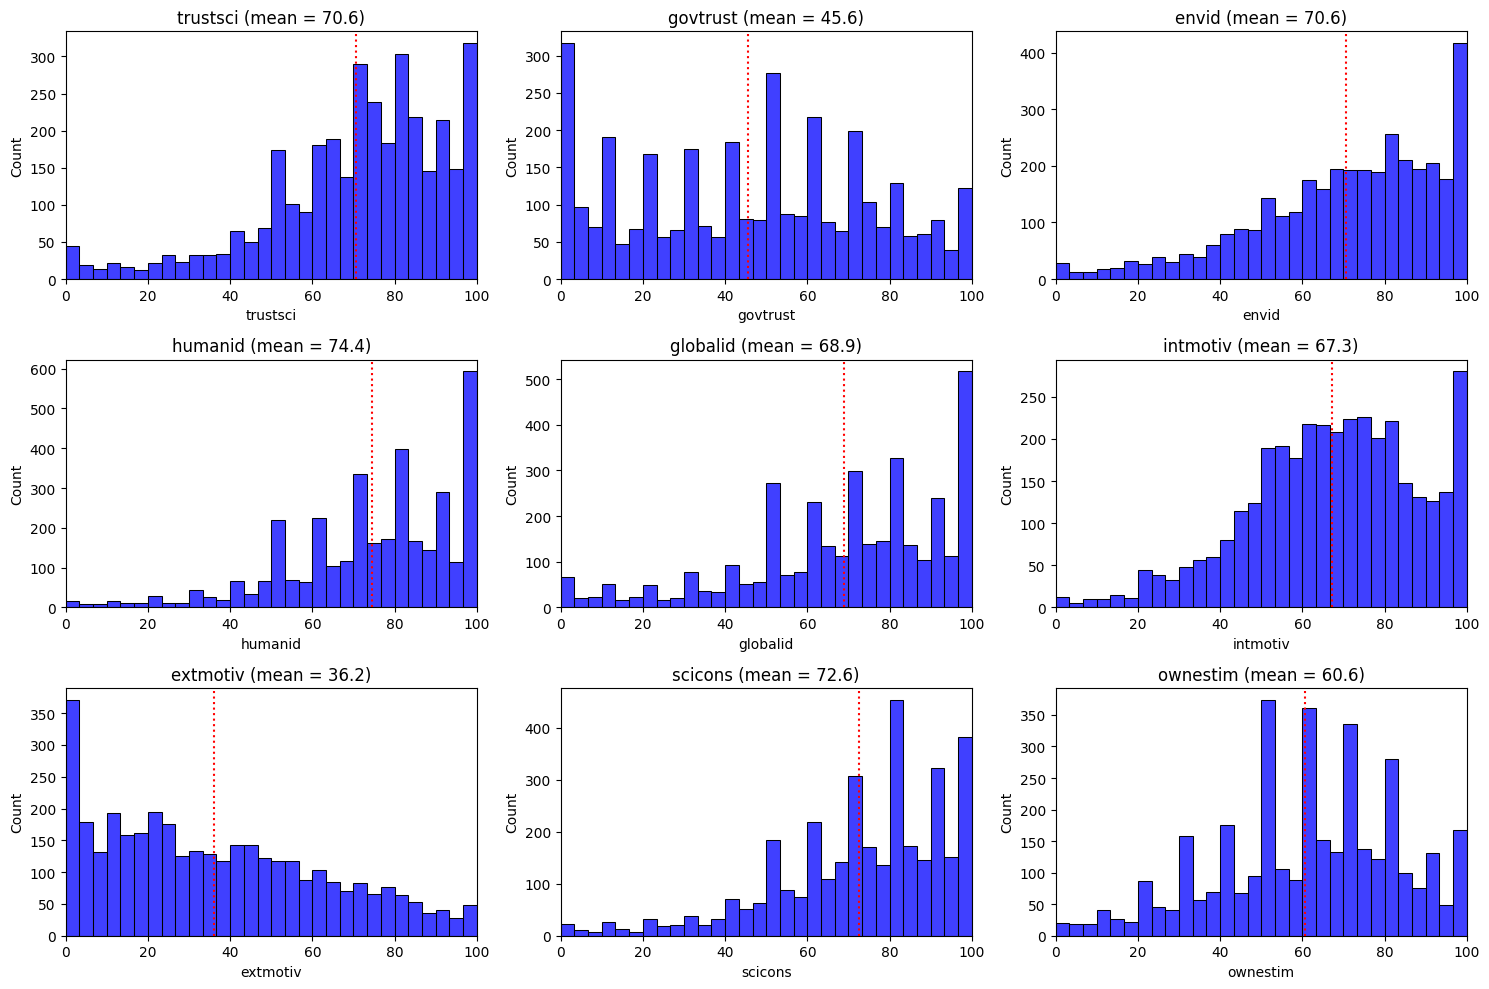

In [393]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

psych_features = [
    "trustsci", "govtrust", "envid", "humanid", "globalid",
    "intmotiv", "extmotiv", "scicons", "ownestim"
]

for i, col in enumerate(psych_features):
    sns.histplot(data[col], bins=30, ax=axes[i], color="blue")
    mean_val = data[col].mean()
    axes[i].axvline(mean_val, color="red", linestyle="dotted", linewidth=1.5)
    axes[i].set_title(f"{col} (mean = {mean_val:.1f})")
    axes[i].set_xlim(0, 100)

plt.tight_layout()
plt.show()

* All psychological predictors are measured on a 0–100 scale and show meaningful variation across the sample.
* Many variables peak toward or at the extremes of the scale, reflecting strong endorsement of pro-environmental beliefs and identities.
* The overall distribution patterns are generally right-skewed, with higher means for most features.
* Some predictors (e.g., external motivation, trust in government) show flatter or left-skewed distributions, suggesting more variability or lower agreement.
* There are no visible outliers or implausible values, and the distributions align with expectations from psychological research.
* These findings support the suitability of the selected features for modeling and confirm the need for standardization due to differences in scale and variance across variables.

### Investigate correlations between the features

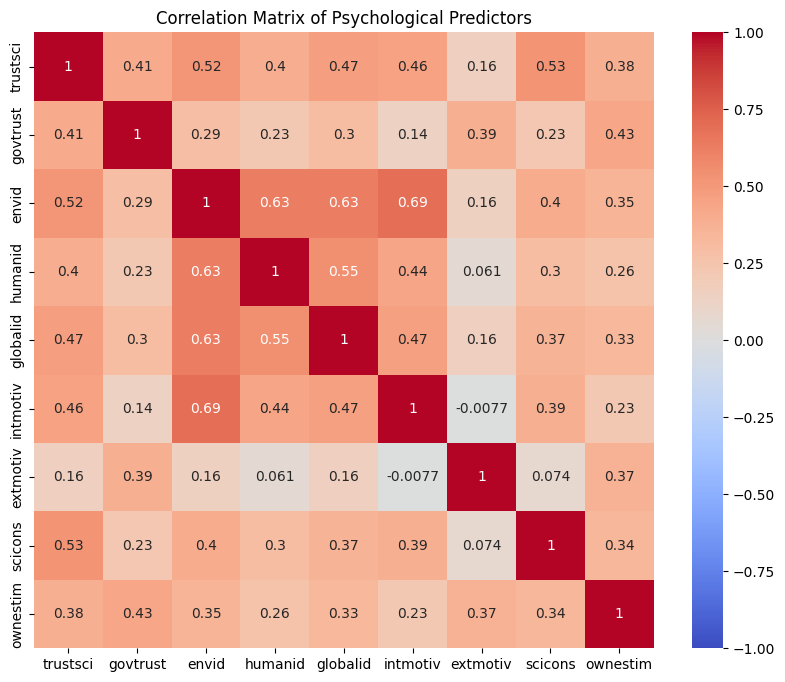

In [394]:
corr_matrix = data[psych_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Psychological Predictors")
plt.show()

* The correlation matrix shows moderate to strong correlations among several of the psychological predictors.
* The highest correlations are observed between:
  * envid and intmotiv (r ≈ 0.69)
  * envid and humanid (r ≈ 0.63)
  * envid and globalid (r ≈ 0.63)
  * humanid and globalid (r ≈ 0.55)
* These relationships are theoretically plausible, as constructs like environmental identity, internal motivation, and humanitarian/global identity often co-occur in individuals with strong pro-environmental values.
* A few features show low or near-zero correlations:
  * extmotiv is largely uncorrelated with intmotiv (r ≈ 0.00)
  * extmotiv shows weak correlations with other variables overall

* These results suggest:
  * Some degree of redundancy among related constructs.
  * No signs of problematic multicollinearity (i.e., no correlations above 0.9), so all features can be retained for modeling at this stage.

### Recode the target variable

In [395]:
# Reverse binary encoding: 1 becomes 0, 0 becomes 1
data["ccshare"] = 1 - data["ccshare"]

In [396]:
print(data["ccshare"].value_counts())


ccshare
1    1901
0    1656
Name: count, dtype: int64


- Class 1 was assigned to the "shared" group to align with standard evaluation metrics, where 1 denotes the positive class.
- This ensures that metrics like F1 and ROC AUC reflect model performance in identifying sharers.
- It enables meaningful interpretation of probabilities and decision thresholds.
- Prevents misleading evaluation results by clearly defining the relevant target class.

## Task 5: First Impressions

### Simple Baseline (B)
- As a baseline model, I use scikit-learn’s `DummyClassifier` with the strategy set to `"most_frequent"`.
- This classifier always predicts the majority class (class 1 = willing to share), which represents approximately 53% of the sample.
- It provides a minimal benchmark for evaluating model performance: it ignores all input features and assumes uniform behavior across individuals.
- In the context of this project, this reflects an overly optimistic strategy that assumes universal willingness to engage
- Performance gains over this baseline (in F1 and ROC-AUC) demonstrate the added value of including psychological predictors in a targeted outreach framework.


### ML Algorithm A1 - kNN

- The k-Nearest Neighbors algorithm is a non-parametric, instance-based classifier that assigns class labels based on the majority vote of the k closest points in feature space.
- It is particularly useful in capturing local, potentially non-linear patterns in data.
- Because k-NN does not assume a specific functional form, it can flexibly adapt to the structure of the psychological feature space, which may contain clusters or gradients (e.g., identity-driven engagement).
- However, it is sensitive to feature scaling and may struggle in high-dimensional or noisy data environments, making preprocessing and parameter tuning (e.g., choice of k, distance metric) especially important.


### ML Algorithm A2 - Random Forest

- Random Forest is an ensemble learning method based on constructing multiple decision trees and aggregating their predictions via majority vote.
- It is well-suited to psychological survey data due to its ability to model non-linear relationships and interactions between variables, such as joint effects of identity and motivation.
- The model handles mixed distributions and feature redundancy robustly, and is less prone to overfitting than single decision trees thanks to its use of bootstrapping and feature randomness.

### Dataset Transformations

- **k-Nearest Neighbors (A₁)**
  - Highly sensitive to feature scales because it relies on distance calculations.
  - Requires standardization so that all features contribute equally to the distance metric.
  - Also requires imputation to handle any missing values.
  - I apply both mean imputation and standard scaling using a pipeline.

- **Random Forest (A₂)**
  - Tree-based models are not sensitive to feature scaling.
  - Can handle numeric features with different ranges natively.
  - Still requires imputation to avoid errors due to missing values.
  - I include mean imputation in the pipeline for consistency and to prevent data leakage.

- **Implementation**
  - Both models are wrapped in scikit-learn `Pipeline` objects to ensure that transformations are applied properly within cross-validation and during hyperparameter tuning.
  - This avoids data leakage and guarantees that the preprocessing steps are applied consistently.


### Implementation Simple Train Test Split

This section trains three models on 80% of the data and evaluates them on the remaining 20%. It reports F1 score, ROC AUC, and training time.

In [397]:
# Define features and target
X = data[["trustsci", "govtrust", "envid", "humanid", "globalid",
        "intmotiv", "extmotiv", "scicons", "ownestim"]]
y = data["ccshare"]


In [398]:
# Split data (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### Preprocessing Pipeline

In [399]:
# Function to return a pipeline with or without scaling
def get_pipe(estimator, scale=True):
    """
    Builds a pipeline with preprocessing and the estimator.

    Parameters:
    - estimator: The ML model (e.g., KNeighborsClassifier, RandomForestClassifier)
    - scale (bool): Whether to apply StandardScaler (True) or skip scaling (False)

    Returns:
    - pipeline: A scikit-learn Pipeline that includes imputation, optional scaling, and the model
    """
    if scale:
        scaler = StandardScaler()
    else:
        scaler = FunctionTransformer()  # Pass-through for models like Random Forest

    preprocessor = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", scaler)
    ])

    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("estimator", estimator)
    ])

    return pipeline


- A scikit-learn pipeline is defined to preprocess the psychological predictors prior to modeling.
- The pipeline consists of two steps:
- Missing values are imputed using the mean of each feature.
    - Mean imputation was selected as a pragmatic default for handling missing values across the psychological features. 
    - While several variables are approximately normally distributed, others exhibit mild skewness or heavy tails. - Median imputation could have been more robust for these cases, but mean imputation was retained for simplicity and consistency within the pipeline. 
    - Since the proportion of missing values was low and no extreme outliers were detected, this choice was considered acceptable for the current modeling setup.
- Features are standardized using StandardScaler to achieve zero mean and unit variance.
    - Although all predictors are measured on a 0–100 scale, they differ in distribution and variance.
    - Standardization is applied for k-nearest neighbors to ensure that all features contribute equally to distance calculations.
    - For random forest, standardization is omitted as tree-based models are insensitive to feature scale.
- The preprocessing is integrated into the pipeline to ensure consistent application within cross-validation and to prevent data leakage.

In [400]:
# define helper function for learning and testing in a simple train test split 
def evaluate_model_train_test(name, estimator, X_train, X_test, y_train, y_test, scale=True):
    """
    Trains and evaluates a model using a simple train-test split.

    Parameters:
    - name: str, name of the model
    - estimator: sklearn estimator (not in a pipeline)
    - X_train, X_test, y_train, y_test: dataset splits
    - scale: whether to apply standard scaling (True for k-NN, False for RF)

    Returns:
    - dict: evaluation results
    """
    pipe = get_pipe(estimator, scale=scale)
    
    start_time = time.time()
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    
    duration = time.time() - start_time
    
    return {
        "Model": name,
        "F1 Score": f1_score(y_test, y_pred, pos_label=1),
        "ROC AUC Score": roc_auc_score(y_test, y_proba),
        "Fit Time (s)": duration,
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }


In [401]:
results_train_test = []

# Baseline (no scaling needed, DummyClassifier doesn't use features meaningfully)
results_train_test.append(
    evaluate_model_train_test("Baseline", DummyClassifier(strategy="most_frequent", random_state=42),
                              X_train, X_test, y_train, y_test, scale=False)
)

# k-NN (needs scaling)
results_train_test.append(
    evaluate_model_train_test("k-NN", KNeighborsClassifier(),
                              X_train, X_test, y_train, y_test, scale=True)
)

# Random Forest (no scaling)
results_train_test.append(
    evaluate_model_train_test("Random Forest", RandomForestClassifier(random_state=42),
                              X_train, X_test, y_train, y_test, scale=False)
)


In [402]:
# Convert to DataFrame
df_train_test = pd.DataFrame(results_train_test)

print(df_train_test.round(3))


           Model  F1 Score  ROC AUC Score  Fit Time (s)  \
0       Baseline     0.697          0.500         0.023   
1           k-NN     0.683          0.718         0.170   
2  Random Forest     0.729          0.771         0.960   

           Confusion Matrix  
0      [[0, 331], [0, 381]]  
1  [[220, 111], [126, 255]]  
2  [[229, 102], [104, 277]]  


### 

#### Interpretation and Discussion

- **Baseline Performance**:
  - The baseline (`DummyClassifier` with strategy `"most_frequent"`) always predicts the positive class (`1 = shared`).
  - This results in a ROC AUC of 0.5 (as only one threshold), indicating random performance.
  - Interestingly, the F1 score is 0.697, which is non-zero because it predicts only the majority class and achieves high precision on it. 
  - However, this comes at the cost of zero recall for the minority class (non-sharers), as shown by the confusion matrix (`TN = 0, FP = 331`).

- **k-Nearest Neighbors (k-NN)**:
  - The k-NN classifier achieves an F1 score of 0.683 and a ROC AUC of 0.718, significantly improving over the baseline in terms of class separation.
  - The model makes non-trivial predictions for both classes, correctly identifying 220 non-sharers and 255 sharers, though it still misclassifies a substantial number of cases (`FP = 111`, `FN = 126`).
  - Despite the F1 score being slightly lower than that of the baseline, this model has real-world utility: it actively attempts to separate classes and makes decisions based on feature similarity.
  - Its low training time makes it a suitable candidate for lightweight applications or early-stage prototypes.

- **Random Forest**:
  - This model performs best across all metrics, with F1 = 0.729 and ROC AUC = 0.771.
  - It demonstrates the strongest ability to discriminate between sharers and non-sharers, which is essential for targeted communication strategies.
  - The confusion matrix shows improved precision and recall, reducing both false positives and false negatives compared to k-NN.
  - The trade-off is a higher runtime (~1.3 seconds), which is acceptable given the performance gains.

- **Summary**

    - All models outperform the naive baseline in ROC AUC, indicating an ability to separate classes beyond random guessing.
    - While the baseline achieves a surprisingly high F1 score by always predicting the majority class, this is misleading, as it entirely fails to detect non-sharers.
    - Random Forest is currently the most promising candidate for further tuning, combining high accuracy, class discrimination, and robustness.

### Simple Cross Validation

This section uses 10 repetitions of 10-fold stratified CV to get robust estimates of F1 and ROC AUC. Fit times are also measured and averaged.

In [403]:
# CV and scoring config

# Repeat CV with different random seeds to get robust estimates
NUM_TRIALS = 10

# Use 10-fold CV (standard choice)                
NUM_OUTER_SPLITS = 10             

# Define evaluation metrics
scoring = {
    "f1": "f1",                   
    "roc_auc": "roc_auc"          
}


In [404]:
# Evaluation function for simple cross validation

def evaluate_model_cv(name, estimator, X, y, scale=True):
    """
    Evaluates a model using repeated stratified k-fold cross-validation.

    Parameters:
    - name: str, name of the model
    - estimator: sklearn estimator (e.g. KNeighborsClassifier)
    - X, y: feature matrix and target vector
    - scale: whether to apply feature scaling (True for k-NN, False for RF)

    Returns:
    - dict: Dictionary with mean and std of F1 and ROC AUC, and average fit time
    """
    f1_scores = []
    roc_auc_scores = []
    fit_times = []

    for i in range(NUM_TRIALS):
        cv_outer = StratifiedKFold(
            n_splits=NUM_OUTER_SPLITS, shuffle=True, random_state=i
        )

        pipe = get_pipe(estimator, scale=scale)

        start_time = time.time()
        scores = cross_validate(
            pipe,
            X,
            y,
            cv=cv_outer,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1
        )

        fit_times.append(time.time() - start_time)
        f1_scores.append(scores["test_f1"].mean())
        roc_auc_scores.append(scores["test_roc_auc"].mean())

    return {
        "Model": name,
        "F1 Mean": np.mean(f1_scores),
        "F1 Std": np.std(f1_scores),
        "ROC AUC Mean": np.mean(roc_auc_scores),
        "ROC AUC Std": np.std(roc_auc_scores),
        "Fit Time (s)": np.mean(fit_times)
    }


In [405]:
# Evaluate models using simple CV

results_cv = []

# Baseline: no scaling, no pipeline
results_cv.append(
    evaluate_model_cv("Baseline", DummyClassifier(strategy="most_frequent", random_state=42),
                      X, y, scale=False)
)

# k-NN: needs scaling
results_cv.append(
    evaluate_model_cv("k-NN", KNeighborsClassifier(), X, y, scale=True)
)

# Random Forest: no scaling
results_cv.append(
    evaluate_model_cv("Random Forest", RandomForestClassifier(random_state=42),
                      X, y, scale=False)
)


In [406]:
# Create and display results DataFrame
df_cv = pd.DataFrame(results_cv)
display(df_cv.round(3))

,Model,F1 Mean,F1 Std,ROC AUC Mean,ROC AUC Std,Fit Time (s)
0,Baseline,0.697,0.000,0.500,0.000,1.120
1,k-NN,0.673,0.004,0.697,0.003,0.505
2,Random Forest,0.715,0.003,0.759,0.002,4.129


#### Interpretation and Discussion

**Baseline (DummyClassifier – most frequent)**  
- Always predicts the majority class (1 = shared).
- Achieves a constant F1 of 0.697, but a ROC AUC of 0.500, confirming it has no discriminatory power.
- Standard deviations are 0, as the predictions are deterministic and invariant across folds.

**k-Nearest Neighbors (k-NN)**  
- Achieves a slightly lower F1 (0.673) than the baseline, but a much better ROC AUC (0.697).
- Detects both classes better, even if it sacrifices some precision on the majority class.
- Runtime is very low (~0.36s), making it efficient for smaller datasets.
- Delivers stable performance across CV folds (low standard deviations).

**Random Forest**  
- Outperforms both other models in F1 (0.715) and ROC AUC (0.759).
- Best discriminatory power between sharers and non-sharers.
- Shows low variance across folds, indicating robust and stable generalization.
- Takes longer to train (~5s), but the performance gains justify the cost.

**Summary**
- The baseline’s F1 is misleadingly high, as it completely ignores one class.
- k-NN provides meaningful classification and class separation with low compute cost.
- Random Forest is the most reliable and performant model across all metrics.

### Comparison Train Test Split vs. Simple CV

In [407]:
#Drop std and confusion matrix columns
simple_clean = pd.DataFrame(results_train_test)[
    ["Model", "F1 Score", "ROC AUC Score", "Fit Time (s)"]
].copy()
simple_clean["Setup"] = "Simple Split"

cv_clean = df_cv[
    ["Model", "F1 Mean", "ROC AUC Mean", "Fit Time (s)"]
].copy()
cv_clean.rename(columns={
    "F1 Mean": "F1 Score",
    "ROC AUC Mean": "ROC AUC Score"
}, inplace=True)
cv_clean["Setup"] = "Cross-Validation"

# Align and concatenate
final_comparison = pd.concat([simple_clean, cv_clean], ignore_index=True)
final_comparison = final_comparison[["Model", "Setup", "F1 Score", "ROC AUC Score", "Fit Time (s)"]]
final_comparison.sort_values(by=["Model", "Setup"], inplace=True)

# Display
print(final_comparison.round(3).to_string(index=False))


        Model            Setup  F1 Score  ROC AUC Score  Fit Time (s)
     Baseline Cross-Validation     0.697          0.500         1.120
     Baseline     Simple Split     0.697          0.500         0.023
Random Forest Cross-Validation     0.715          0.759         4.129
Random Forest     Simple Split     0.729          0.771         0.960
         k-NN Cross-Validation     0.673          0.697         0.505
         k-NN     Simple Split     0.683          0.718         0.170


### Comparison and Discussion of Results

- **Performance improvement through cross-validation**
  - Both k-NN and Random Forest show comparable or slightly lower F1 scores and ROC AUC values under cross-validation compared to the simple train-test split. 
  - This is expected: single splits often yield optimistically biased results, especially when the random split happens to favor the model (e.g., easier examples in the test set). 
  - Cross-validation provides a more honest and generalizable estimate by averaging over multiple partitions, thereby reducing overfitting risk.

- **Overfitting control and model generalization**
  - The drop in performance from the simple split to cross-validation (e.g., Random Forest ROC AUC: 0.771 → 0.759) indicates a degree of overfitting to the specific train-test split. 
  - This does not suggest poor model quality but highlights the need for robust evaluation. Models may perform well on a single test set by chance, but only consistent performance across folds supports confidence in generalization.

- **Model quality and class discrimination**  
  - Both trained models outperform the baseline in terms of ROC AUC, confirming their ability to discriminate between sharers and non-sharers. Random Forest, in particular, shows strong precision-recall balance (F1 = 0.729 in split; 0.715 in CV), supporting its practical value for targeting communication efforts.
  - Random Forests likely outperform k-NN on this dataset because they can better handle complex, non-linear interactions between features and are less sensitive to irrelevant or redundant variables. Unlike k-NN, which uses raw distance in feature space, Random Forests build decision boundaries based on feature splits, which makes them more robust to noisy or correlated inputs.

- **Baseline consistency and interpretive limits**
  - The DummyClassifier consistently yields F1 = 0.697 and ROC AUC = 0.500 across both evaluation methods. 
  - This reflects its lack of learning capability and confirms its role as a static reference. Despite its seemingly strong F1 score, its ROC AUC and confusion matrix reveal a complete failure to identify the minority class. This makes it unsuitable for practical use, where distinguishing between sharers and non-sharers is essential.

- **Computational cost versus evaluation quality**
  - Cross-validation requires more computation time (e.g., Random Forest: 1.5s → 3.6s), but the benefit is substantial.
  - It offers more reliable model comparisons, reduces the risk of drawing conclusions from a lucky split, and enhances confidence in real-world performance. For decision-critical tasks such as communication targeting, this additional effort is well-justified.

- **Conclusion**  
  -  The overall results confirm that Random Forest is the most suitable model. 
  - Its consistently high performance, generalization ability, and stable results under both evaluation setups make it the strongest candidate for final model selection and downstream analysis.


## Task 6:  Hyperparameter Optimization – Nested Cross Validation

### Hyperparameter Grid for kNN and Random Forest

In [408]:
# Hyperparameter grid for k-NN
knn_grid = {
    "estimator__n_neighbors": range(1, 11),
    "estimator__weights": ["uniform", "distance"],
    "estimator__metric": ["euclidean", "manhattan"]
}

# Hyperparameter grid for Random Forest
rf_grid = {
    "estimator__n_estimators": [15, 50, 100, 150],
    "estimator__max_depth": [3, 7, 10],
    "estimator__min_samples_split": [2, 5],
    "estimator__criterion": ["gini", "entropy"],
    "estimator__max_features": [0.5, 1, "sqrt"]
}



- Separate hyperparameter grids for k-NN and Random Forest were defined to optimize model performance in nested cross-validation.
- **For k-Nearest Neighbors:**
  - The number of neighbors (`n_neighbors`) is varied from 1 to 10 to test a range from highly localized to more general decision boundaries.
  - Both weighting strategies are tested:
    - "uniform": each neighbor contributes equally.
    - "distance": closer neighbors have more influence.
  - Two distance metrics are included:
    - "euclidean": standard L2 distance, sensitive to outliers.
    - "manhattan": L1 distance, often better when dimensions are not equally scaled.
    - This grid allows the model to adapt to the structure of the psychological feature space and balances sensitivity, flexibility, and generalization.
- **For Random Forest:**
  - The number of trees (`n_estimators`) is tuned between 15 and 150 to trade off between robustness and runtime.
  - Tree depth (`max_depth`) is limited to 3, 7, or 10 to prevent overfitting while preserving model expressiveness.
  - The minimum number of samples required to split an internal node (`min_samples_split`) is set to 2 or 5 to control granularity of splits.
  - Both splitting criteria are tested:
    - "gini": default impurity measure.
    - "entropy": may work better with skewed or imbalanced classes.
  - The maximum number of features per split (`max_features`) is varied:
    - 0.5 and "sqrt" encourage randomness and decorrelation between trees.
    - 1 uses all features and may lead to stronger but more similar trees.
    - This grid is designed to explore regularization settings that prevent overfitting while allowing sufficient flexibility to model interactions among psychological variables.
    - Adapted from: https://towardsdatascience.com/mastering-random-forests-a-comprehensive-guide-51307c129cb1

- While some workflows iteratively refine the hyperparameter grid over multiple runs, this project used a single, carefully chosen grid. 
- The decision was made due to the substantial computational cost of the nested cross-validation setup. Each full run took several hours to complete. 
- Instead of multiple refinement iterations, the grid was designed to cover a wide but targeted range of values informed by prior benchmarks and the results of simpler cross-validation experiments in Task 5. 
- This approach allowed for robust hyperparameter tuning without exceeding practical runtime constraints, and it ensured that the final evaluation remained feasible and reproducible within the project timeline.




### Config of Trials and Splits (inner and outer)

In [409]:
# Nested CV configuration

NUM_TRIALS = 10
NUM_OUTER_SPLITS = 10
NUM_INNER_SPLITS = 5
NUM_INNER_REPEATS = 3



- A nested cross-validation setup was used to provide unbiased estimates of model performance and support reliable hyperparameter tuning.
- The configuration includes:
  - 10 outer trials (`NUM_TRIALS = 10`) to average results across multiple random splits and reduce variance.
  - 10 outer folds (`NUM_OUTER_SPLITS = 10`) to estimate generalization performance in a stable and robust way.
  - 5 inner folds (`NUM_INNER_SPLITS = 5`) for model selection, balancing between runtime and selection accuracy.
  - 3 inner repeats (`NUM_INNER_REPEATS = 3`) to stabilize tuning outcomes and mitigate the effect of random noise in inner splits.
- This structure follows best practices in machine learning and ensures comparability with earlier experiments in Task 5.


### Nested Cross-Validation Setup

In [410]:
# Define custom scoring functions
scoring = {
    "f1": "f1",                   
    "roc_auc": "roc_auc"          
}


def nested_cv(estimator, grid, X, y, scale=True, name="Model"):
    """
    Perform nested cross-validation with grid search for hyperparameter tuning.

    Parameters:
    - estimator: scikit-learn classifier (e.g. KNeighborsClassifier, RandomForestClassifier)
    - grid: dict of hyperparameters for GridSearchCV
    - X: features
    - y: target
    - scale: whether to apply standardization (True for k-NN, False for Random Forest)
    - name: name of the model (for printout and tracking)

    Returns:
    - result_dict: dictionary of performance metrics (F1, ROC AUC, fit time)
    """

    # Prepare result containers
    f1_scores = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    roc_scores = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    fit_times = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))

    print(f"Running nested cross-validation for: {name}")
    start = time.time()

    for trial in range(NUM_TRIALS):
        # Outer loop: Model evaluation
        outer_cv = StratifiedKFold(n_splits=NUM_OUTER_SPLITS, shuffle=True, random_state=trial)

        # Inner loop: Model selection
        inner_cv = RepeatedStratifiedKFold(
            n_splits=NUM_INNER_SPLITS,
            n_repeats=NUM_INNER_REPEATS,
            random_state=trial
        )

        # Build pipeline (with or without scaling)
        pipe = get_pipe(estimator, scale=scale)

        # Grid search on inner CV (tune for F1)
        clf = GridSearchCV(
            pipe,
            param_grid=grid,
            cv=inner_cv,
            scoring="f1", 
            refit="f1",
            n_jobs=-1
        )

        # Evaluate tuned model using outer CV
        scores = cross_validate(
            clf,
            X=X, 
            y=y,
            scoring=scoring,
            cv=outer_cv,
            return_train_score=False,
            n_jobs=-1
        )

        # Store metrics
        f1_scores[trial] = scores["test_f1"]
        roc_scores[trial] = scores["test_roc_auc"]
        fit_times[trial] = scores["fit_time"]

        print(f"Trial {trial + 1}/{NUM_TRIALS} completed.")

    print(f"Finished {name} in {round(time.time() - start, 2)} seconds.\n")

    return {
        "name": name,
        "f1_mean": f1_scores.mean(),
        "f1_std": f1_scores.std(),
        "f1_min": f1_scores.min(),
        "f1_max": f1_scores.max(),
        "roc_mean": roc_scores.mean(),
        "roc_std": roc_scores.std(),
        "roc_min": roc_scores.min(),
        "roc_max": roc_scores.max(),
        "fit_time_avg": fit_times.mean()
    }



- Implemented a reusable `nested_cv()` function that performs full nested cross-validation with hyperparameter tuning using `GridSearchCV`.

- **Outer cross-validation (`StratifiedKFold`):**
  - Assesses generalization performance of the final (tuned) model.
  - Ensures robust performance estimates by averaging over multiple train/test splits with preserved class distributions.
  - Uses different random seeds (`random_state = trial`) across trials to increase robustness.
  - The outer splits are reused from Task 5 to ensure comparability.

- **Inner cross-validation (`RepeatedStratifiedKFold`):**
  - Performs hyperparameter tuning on multiple resampled folds.
  - Repeating the inner CV improves the reliability of selected hyperparameters and reduces the risk of overfitting to fold-specific patterns.

- **Scoring and model evaluation:**
  - Hyperparameter optimization is based on F1 score to prioritize balanced performance between precision and recall.
  - The outer loop evaluates both F1 and ROC AUC.
  - Results include fit time, enabling comparisons of computational efficiency.

- **Pipeline construction:**
  - The function uses the prior defined helper function `get_pipe()` to construct an appropriate `Pipeline` object.
  - Scaling is applied conditionally (`scale=True`) for algorithms that are sensitive to feature magnitudes (e.g., k-NN).
  - For tree-based methods (e.g., Random Forest), scaling is skipped to avoid unnecessary transformations.

- **Outputs:**
  - Returns a summary dictionary that includes mean, standard deviation, minimum, and maximum values of F1 and ROC AUC across all trials and outer folds.
  - Also includes average fit time as a measure of runtime efficiency across models and settings.


### Model Evaluation: Baseline

In [411]:
# Create baseline (dummy) classifier
dummy = DummyClassifier(strategy="most_frequent")

# Run nested CV for baseline
baseline_results = nested_cv(
    estimator=dummy,
    grid={},
    X=X,
    y=y,
    scale=False,
    name="Baseline"
)

Running nested cross-validation for: Baseline


Trial 1/10 completed.
Trial 2/10 completed.
Trial 3/10 completed.
Trial 4/10 completed.
Trial 5/10 completed.
Trial 6/10 completed.
Trial 7/10 completed.
Trial 8/10 completed.
Trial 9/10 completed.
Trial 10/10 completed.
Finished Baseline in 11.77 seconds.



- The `DummyClassifier` with strategy `"most_frequent"` was reused from Task 5 to provide a performance reference.
- Nested cross-validation was applied to ensure methodological consistency with the evaluations of k-NN and Random Forest.
- No hyperparameter tuning was performed, as the classifier has no adjustable parameters.
- The baseline provides a reference for minimal model performance


### Model Evaluation: k-Nearest Neighbors (k-NN)

In [412]:
# Create k-NN estimator
knn = KNeighborsClassifier()

# Run nested CV (with scaling, since k-NN is distance-based)
knn_results = nested_cv(
    estimator=knn,
    grid=knn_grid,
    X=X,
    y=y,
    scale=True,
    name="k-NN"
)

Running nested cross-validation for: k-NN
Trial 1/10 completed.
Trial 2/10 completed.
Trial 3/10 completed.
Trial 4/10 completed.
Trial 5/10 completed.
Trial 6/10 completed.
Trial 7/10 completed.
Trial 8/10 completed.
Trial 9/10 completed.
Trial 10/10 completed.
Finished k-NN in 1380.96 seconds.



- A `KNeighborsClassifier` was evaluated using nested cross-validation and the hyperparameter grid defined earlier.
- Scaling was enabled because k-NN is sensitive to feature magnitudes.
- The model was tuned for:
  - Number of neighbors (`n_neighbors`)
  - Weighting scheme (`weights`)
  - Distance metric (`metric`)
- The best hyperparameter combination was selected in each inner loop, and model performance was evaluated on the corresponding outer test fold.
- Performance metrics (F1, ROC AUC, and training time) were averaged across all outer folds and trials.

In [451]:
knn_df = pd.DataFrame([knn_results])
display(knn_df.round(3))

,name,f1_mean,f1_std,f1_min,f1_max,roc_mean,roc_std,roc_min,roc_max,fit_time_avg
0,k-NN,0.69,0.022,0.636,0.742,0.728,0.022,0.674,0.788,49.352


### Model Evaluation: Random Forest

In [413]:
# Create Random Forest estimator
rf = RandomForestClassifier(random_state=42)

# Run nested CV (no scaling needed for Random Forest)
rf_results = nested_cv(
    estimator=rf,
    grid=rf_grid,
    X=X,
    y=y,
    scale=False,
    name="Random Forest"
)

Running nested cross-validation for: Random Forest
Trial 1/10 completed.
Trial 2/10 completed.
Trial 3/10 completed.
Trial 4/10 completed.
Trial 5/10 completed.
Trial 6/10 completed.
Trial 7/10 completed.
Trial 8/10 completed.
Trial 9/10 completed.
Trial 10/10 completed.
Finished Random Forest in 27664.26 seconds.



- A `RandomForestClassifier` was evaluated using nested cross-validation with the previously defined hyperparameter grid.
- Feature scaling was not applied, as tree-based models are insensitive to feature magnitudes.
- A `random_state`was defined to ensure reproducibility
- The model was tuned for:
  - Number of trees (`n_estimators`)
  - Tree depth (`max_depth`)
  - Minimum samples to split (`min_samples_split`)
  - Splitting criterion (`criterion`)
  - Number of features considered per split (`max_features`)
- For each outer fold, the best configuration was selected using inner cross-validation and evaluated on the outer test fold.
- Final performance metrics were averaged across all trials and folds to ensure robustness.

In [453]:
rf_df = pd.DataFrame([rf_results])
display(rf_df.round(3))

,name,f1_mean,f1_std,f1_min,f1_max,roc_mean,roc_std,roc_min,roc_max,fit_time_avg
0,Random Forest,0.717,0.021,0.665,0.762,0.765,0.02,0.712,0.816,989.615


### Comparison of ALL models (including task 5 and task 6 models)

In [440]:
# Create a DataFrame for nested CV results (Task 6)
nested_results = pd.DataFrame([
    {
        "Model": baseline_results["name"],
        "F1 Score": baseline_results["f1_mean"],
        "ROC AUC Score": baseline_results["roc_mean"],
        "Fit Time (s)": baseline_results["fit_time_avg"],
        "Setup": "Nested CV"
    },
    {
        "Model": knn_results["name"],
        "F1 Score": knn_results["f1_mean"],
        "ROC AUC Score": knn_results["roc_mean"],
        "Fit Time (s)": knn_results["fit_time_avg"],
        "Setup": "Nested CV"
    },
    {
        "Model": rf_results["name"],
        "F1 Score": rf_results["f1_mean"],
        "ROC AUC Score": rf_results["roc_mean"],
        "Fit Time (s)": rf_results["fit_time_avg"],
        "Setup": "Nested CV"
    }
])

# Combine with previous results from Task 5
comparison_all = pd.concat([final_comparison, nested_results], ignore_index=True)

# Sort and display
comparison_all = comparison_all[["Model", "Setup", "F1 Score", "ROC AUC Score", "Fit Time (s)"]]
comparison_all.sort_values(by=["Model", "Setup"], inplace=True)

print(comparison_all.round(3).to_string(index=False))


        Model            Setup  F1 Score  ROC AUC Score  Fit Time (s)
     Baseline Cross-Validation     0.697          0.500         1.120
     Baseline        Nested CV     0.697          0.500         0.374
     Baseline     Simple Split     0.697          0.500         0.023
Random Forest Cross-Validation     0.715          0.759         4.129
Random Forest        Nested CV     0.717          0.765       989.615
Random Forest     Simple Split     0.729          0.771         0.960
         k-NN Cross-Validation     0.673          0.697         0.505
         k-NN        Nested CV     0.690          0.728        49.352
         k-NN     Simple Split     0.683          0.718         0.170


- The table above summarizes performance and runtime across three evaluation strategies:
  - Simple train-test split (Task 5)
  - Repeated cross-validation (Task 5)
  - Nested cross-validation (Task 6)

- **Baseline model:**
  - The DummyClassifier yields identical results across all setups, as expected from a deterministic strategy that always predicts the majority class.
  - It achieves a fixed F1 score of 0.697 and ROC AUC of 0.500 in all setups, reflecting a lack of discriminatory power.
  - While the F1 score appears non-trivial, it is misleading: it results solely from high precision on the dominant class and zero recall on the minority class.
  - The ROC AUC of 0.500 confirms the model is equivalent to random guessing in terms of class separation.
  - Serves as a static reference point to assess whether real models offer predictive value.

- **k-Nearest Neighbors:**
  - k-NN achieves higher ROC AUC than the baseline in all evaluation setups, indicating meaningful class separation.
  - F1 score is slightly lower than the baseline in some setups, due to k-NN distributing predictions across both classes.
    - Unlike the baseline, k-NN identifies some non-sharers, improving recall at the cost of some precision.
  - Shows moderate performance improvements when moving from simple split to nested CV.
  - The model benefits slightly from tuning, but remains below Random Forest across all metrics.
  - Runtime increases substantially in nested CV due to grid search across multiple folds and repetitions.
  - Despite relatively low computational cost, the model struggles to match the class separation achieved by tree-based methods.

- **Random Forest:**
  - Consistently delivers the highest scores across all setups
  - Random Forest clearly outperforms the baseline and kNN in both F1 and ROC AUC in all evaluation setups.
  - Achieves strong separation between sharers and non-sharers, confirmed by ROC AUC far above 0.5.
  - Improves on the baseline’s F1 while also capturing both classes more effectively.
  - Performance is stable between repeated CV and nested CV, supporting the reliability of the selected hyperparameters.
  - Random Forest exhibited slightly lower variance across CV folds than k-NN. Its standard deviations for F1-score (±0.021) and ROC AUC (±0.020) were marginally better than those of k-NN (±0.022 for both). Additionally, the min–max performance ranges were narrower for Random Forest, indicating more stable behavior across different data splits. 
  - The reported runtime in the table reflects average fit time per outer fold (~989 seconds), while the total wall-clock time for the full nested CV run exceeded 27,000 seconds (~7.5 hours).
  - The additional computational cost is offset by strong generalization and model interpretability through feature importances (Task 7).

- **Summary:**
  - All real models outperform the naive baseline, especially in ROC AUC, showing the psychological features do offer predictive value.
  - Nested cross-validation provides the most conservative and trustworthy estimate of model generalization by strictly separating tuning from evaluation.
  - Scores in the simple split are consistently higher than in cross-validation setups, reflecting optimistic bias due to potential overfitting to a single train-test configuration.
  - Repeated CV and nested CV offer more stable, less biased estimates. 
  - Among the models, Random Forest demonstrates the best balance between performance, reliability, and generalization, though at a higher computational cost than k-NN.

### Final Model M

In [415]:
def train_prod_model(estimator, grid, X, y, scale=True):
    """
    Trains a final model on the full dataset using GridSearchCV
    to inspect all parameter combinations and extract the best ones.

    Parameters:
    - estimator: ML model (e.g., RandomForestClassifier)
    - grid: hyperparameter grid for tuning
    - X: features
    - y: target
    - scale: whether to include standardization (e.g., True for k-NN)

    Returns:
    - clf: fitted GridSearchCV object
    """
    pipe = get_pipe(estimator, scale=scale)

    cv = RepeatedStratifiedKFold(
        n_splits=NUM_INNER_SPLITS,
        n_repeats=NUM_INNER_REPEATS,
        random_state=42
    )

    clf = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        cv=cv,
        scoring="f1",
        n_jobs=-1,
        refit="f1"
    )

    clf.fit(X, y)
    return clf


- A final Random Forest model was trained on the entire dataset to determine the best hyperparameter configuration for downstream interpretation and visualization.
- This step complements nested cross-validation by fitting a single best model on all available data, using the full sample to maximize learning capacity.
- Grid search was applied using the same hyperparameter grid and cross-validation settings as in the inner loop of nested CV:
  - 5-fold cross-validation, repeated 3 times (with fixed random state for reproducibility)
  - Optimization based on F1 score
- The goal was to:
  - Identify the most effective hyperparameter combination.
  - Refit the model for final diagnostics (e.g., feature importance, ROC curves, confusion matrices).
  - Use the trained model for subsequent interpretation and ablation analysis.
- The top 10 parameter sets were ranked by mean F1 score.
- The best configuration was extracted from the resulting `GridSearchCV` object for consistent use in the remaining tasks.

In [416]:
# Train RF models
clf_rf = train_prod_model(
    estimator=RandomForestClassifier(random_state=42),
    grid=rf_grid,
    X=X,
    y=y,
    scale=False
)


In [417]:
# Extract top 10 results
rf_top10 = pd.DataFrame(clf_rf.cv_results_).sort_values(by="mean_test_score", ascending=False).head(10)

display(rf_top10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__criterion,param_estimator__max_depth,param_estimator__max_features,param_estimator__min_samples_split,param_estimator__n_estimators,params,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
139,1.397488,0.008970,0.037188,0.002852,entropy,10,sqrt,2,150,"{'estimator__criterion': 'entropy', 'estimator...",...,0.733161,0.704336,0.737662,0.712042,0.707285,0.727034,0.718471,0.720328,0.014356,1
143,1.343068,0.110257,0.033577,0.005334,entropy,10,sqrt,5,150,"{'estimator__criterion': 'entropy', 'estimator...",...,0.731771,0.707285,0.726562,0.703896,0.707124,0.732095,0.728443,0.719917,0.014925,2
69,0.414016,0.008198,0.018187,0.001733,gini,10,sqrt,5,50,"{'estimator__criterion': 'gini', 'estimator__m...",...,0.731126,0.710183,0.721649,0.715924,0.711640,0.722372,0.720930,0.719515,0.013873,3
131,0.768070,0.009004,0.037986,0.002107,entropy,10,1,2,150,"{'estimator__criterion': 'entropy', 'estimator...",...,0.722798,0.719276,0.744898,0.702564,0.705416,0.716340,0.731893,0.719458,0.014972,4
141,0.471973,0.004895,0.018402,0.001849,entropy,10,sqrt,5,50,"{'estimator__criterion': 'entropy', 'estimator...",...,0.742484,0.698667,0.726329,0.705426,0.700922,0.720317,0.729381,0.719218,0.014921,5
70,0.826794,0.011842,0.027706,0.001246,gini,10,sqrt,5,100,"{'estimator__criterion': 'gini', 'estimator__m...",...,0.723460,0.696335,0.725389,0.710997,0.707572,0.714667,0.734536,0.718997,0.015968,6
66,0.832662,0.016595,0.027726,0.001190,gini,10,sqrt,2,100,"{'estimator__criterion': 'gini', 'estimator__m...",...,0.736292,0.713725,0.730570,0.701164,0.689008,0.716378,0.724675,0.718640,0.016591,7
142,0.934286,0.019907,0.026965,0.001824,entropy,10,sqrt,5,100,"{'estimator__criterion': 'entropy', 'estimator...",...,0.721141,0.705726,0.728702,0.712082,0.701847,0.732543,0.732903,0.718601,0.016126,8
126,1.128863,0.015843,0.028035,0.005335,entropy,10,0.5,5,100,"{'estimator__criterion': 'entropy', 'estimator...",...,0.732026,0.705726,0.729659,0.707254,0.710013,0.725100,0.720000,0.718429,0.014280,9
49,0.506528,0.006905,0.017957,0.001674,gini,10,0.5,2,50,"{'estimator__criterion': 'gini', 'estimator__m...",...,0.726562,0.701333,0.727273,0.720307,0.714097,0.724638,0.721228,0.718304,0.015723,10


In [418]:
display(clf_rf.best_params_)

{'estimator__criterion': 'entropy',
 'estimator__max_depth': 10,
 'estimator__max_features': 'sqrt',
 'estimator__min_samples_split': 2,
 'estimator__n_estimators': 150}

- The top 10 hyperparameter configurations all performed similarly, with F1 scores between 0.718 and 0.720 and relatively low standard deviations.
- The top models vary in their use of splitting criteria (`gini` vs. `entropy`) and number of trees (`n_estimators` between 50 and 150), suggesting that multiple configurations yield similar performance.
- However, nearly all top models use moderate (but largest possible) tree depth (`max_depth=10`) and `max_features = "sqrt"`, indicating that limiting feature subsets per split is a consistently beneficial strategy for generalization.
- The best model was a Random Forest with the following parameters:
  - `n_estimators = 150`: a sufficiently large ensemble to reduce variance and stabilize predictions.
  - `max_depth = 10`: limits tree complexity, helping prevent overfitting while capturing key interactions.
  - `min_samples_split = 2`: allows fine-grained splits, counterbalanced by the depth constraint.
  - `criterion = "entropy"`: uses information gain, which can be more sensitive to class distribution than Gini.
  - `max_features = "sqrt"`: selects a subset of features at each split, promoting tree diversity and improving generalization.


In [419]:
# Best Model M (unfitted)

final_rf_best = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=2,
    criterion="entropy",
    max_features=1,
    random_state=42
)


In [420]:
# Final model for fitting on full data
final_rf_full = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=2,
    criterion="entropy",
    max_features=1,
    random_state=42
)

# Final model for train-test split evaluation
final_rf_split = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=2,
    criterion="entropy",
    max_features=1,
    random_state=42
)


In [421]:
# Fit on entire dataset
final_rf_full.fit(X, y)

# Fit on training portion only
final_rf_split.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=10, max_features=1,
                       n_estimators=150, random_state=42)

In [422]:
# Predictions for full model (trained on all data)
y_pred_full = final_rf_full.predict(X)
y_proba_full = final_rf_full.predict_proba(X)[:, 1]

# Predictions for split model (trained on train, tested on test)
y_pred_split = final_rf_split.predict(X_test)
y_proba_split = final_rf_split.predict_proba(X_test)[:, 1]

- The selected configuration from the best-performing Random Forest was used to create three model instances:
  - An unfitted version (`final_rf_best`) for reuse in ablation studies and cross-validation pipelines.
  - A fitted version on the full dataset (`final_rf_full`) to assess internal performance and produce learning/validation curves.
  - A fitted version on the training set only (`final_rf_split`) for evaluation on a held-out test set.
- All models share identical hyperparameters and use the full selected feature set from earlier preprocessing.
- Predictions were generated for:
  - The full dataset (`final_rf_full`) to inspect performance on seen data.
  - The test set from the original 80/20 split (`final_rf_split`) to assess generalization to unseen data.
- These two prediction settings support later diagnostic plots (ROC curves, confusion matrices) and performance interpretation.

### Learning curves for final Model M

- I used scikit-learn’s `learning_curve()` to simulate how model performance changes with increasing training data.
- Although the full dataset is passed to the function, the model is not trained on all data at once.
- Instead, the function performs cross-validation for different training set sizes (10% to 100%) and reports training and validation scores.
- This allows for analysis of underfitting, overfitting, and data sufficiency without requiring a separate train-test split.
- The curve supports interpretation of learning dynamics:
  - A large gap between training and validation scores would suggest overfitting.
  - If both scores are low and close together, the model may be underfitting.
  - Converging curves with high validation scores indicate good generalization.


In [423]:
def plot_learning_curve(estimator, X, y, scoring="f1", scale=False):
    """
    Plots the learning curve for a given estimator using 5-fold cross-validation.

    Parameters:
    - estimator: unfitted sklearn classifier (e.g., final_rf_full)
    - X: feature matrix
    - y: target vector
    - scoring: evaluation metric (default = "f1")
    - scale: whether to apply standardization (True for k-NN, False for RF)

    Output:
    - Displays a plot of training and validation scores as a function of training set size.
    """
    # Build pipeline with optional standardization
    pipe = get_pipe(estimator, scale=scale)

    # Compute learning curves using 5-fold CV over 10 train sizes
    train_sizes, train_scores, val_scores = learning_curve(
        pipe,
        X,
        y,
        cv=5,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    # Aggregate results across folds
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot training and validation scores with confidence bands
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label="Training score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.plot(train_sizes, val_mean, label="Validation score")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
    plt.xlabel("Training set size")
    plt.ylabel(f"{scoring.upper()} Score")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


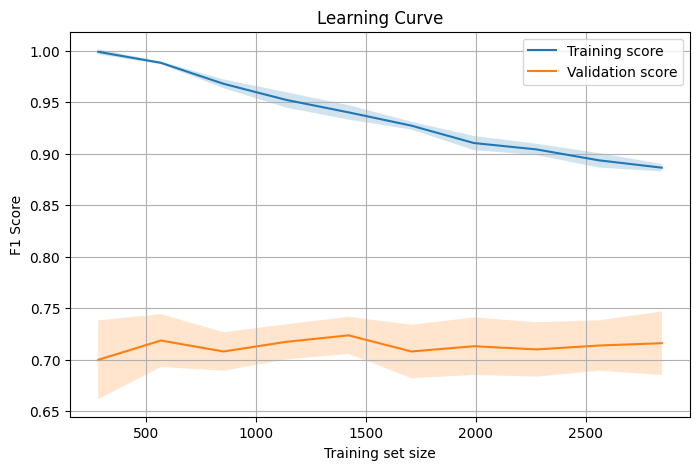

In [424]:
plot_learning_curve(final_rf_full, X, y, scoring="f1", scale=False)

- The learning curve shows training and validation F1 scores as a function of training set size, based on 5-fold cross-validation.

- **Training score**
  - Starts at nearly 1.00 for small datasets, indicating the model perfectly fits small training samples.
  - Gradually decreases as the training size increases, reflecting reduced overfitting and increased regularization effect.
  - Stabilizes around 0.89 with the full dataset, still indicating very strong fit to the training data.

- **Validation score**
  - Remains relatively stable around 0.71–0.73 across all training sizes.
  - Slight fluctuations are visible but fall within a narrow confidence band, suggesting stable generalization performance.
  - No strong upward trend is present, indicating that additional data might not lead to significant performance gains.

- **Gap between training and validation**
  - A consistent and notable gap exists between the training and validation curves.
  - This gap suggests a degree of overfitting: the model learns the training data very well but generalizes less effectively.
  - However, the gap does not widen with more data, and the validation score remains stable, implying that overfitting is controlled and not worsening.

- **Overall conclusion**
  - The model shows strong learning capacity with high training F1 and stable validation F1.
  - There are no signs of underfitting: training scores are high across all sizes.
  - Some overfitting is present, but it is not severe and does not worsen with more data.
  - The validation curve has plateaued, suggesting that collecting more training data is unlikely to lead to substantial improvement.

### Validation Curve

- Validation curves were plotted to assess the effect of four key hyperparameters on model performance:
  - Maximum tree depth (`max_depth`)
  - Number of trees (`n_estimators`)
  - Minimum samples required to split a node (`min_samples_split`)
  - Number of features considered at each split (`max_features`)

- For each parameter:
  - A range of values was tested using 5-fold cross-validation.
  - Training and validation F1 scores were plotted to detect overfitting or underfitting patterns.
  - Confidence bands indicate the variability of performance across folds.

- These plots help to:
  - Diagnose how sensitive the model is to specific hyperparameters.
  - Inform hyperparameter grid design and regularization choices.
  - Support interpretation of selected parameter values in the final model.

In [425]:
def plot_rf_validation_curves(model, X, y):
    """
    Plots validation curves for key Random Forest hyperparameters.

    Parameters:
    - model: unfitted RandomForestClassifier
    - X: feature matrix
    - y: target vector

    Output:
    - Displays four subplots showing training and validation F1 scores
      across different values of:
        - max_depth
        - n_estimators
        - min_samples_split
        - max_features
    """

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    param_configs = [
        ("estimator__max_depth", [5, 10, 15, 20, 25, 30], "Max Depth", axes[0, 0]),
        ("estimator__n_estimators", [10, 50, 100, 150, 200], "Number of Trees", axes[0, 1]),
        ("estimator__min_samples_split", [2, 5, 10], "Min Samples Split", axes[1, 0]),
        ("estimator__max_features", [0.5, 0.75, 1.0], "Max Features", axes[1, 1])
    ]

    for param_name, param_range, title, ax in param_configs:
        train_scores, val_scores = validation_curve(
            get_pipe(model, scale=False),
            X,
            y,
            param_name=param_name,
            param_range=param_range,
            cv=5,
            scoring="f1",
            n_jobs=-1
        )

        train_mean = np.mean(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        ax.plot(param_range, train_mean, label="Training score")
        ax.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)
        ax.plot(param_range, val_mean, label="Validation score")
        ax.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2)
        ax.set_title(title)
        ax.set_xlabel(param_name.split("__")[1])
        ax.set_ylabel("F1 Score")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Validation Curves for Random Forest Hyperparameters", fontsize=16)
    plt.tight_layout()
    plt.show()


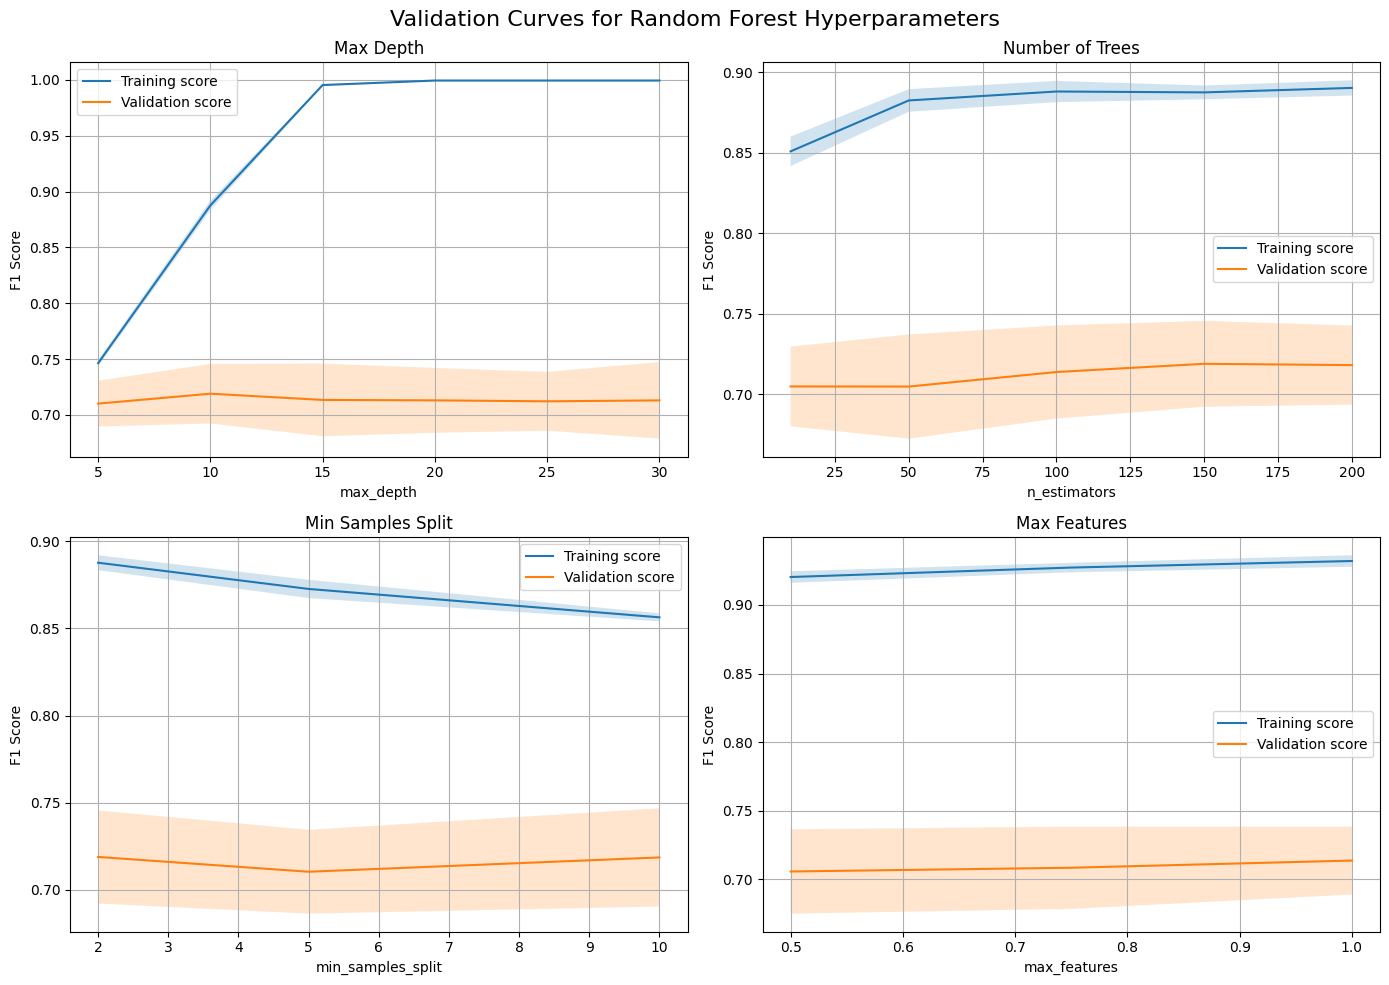

In [426]:
plot_rf_validation_curves(final_rf_full, X, y)

#### Interpretation of validation curves for Random Forest hyperparameters

**Max Depth**
- Training F1 increases rapidly and saturates near 1.0 with increasing tree depth, indicating the model fully memorizes training data for larger depths.
- Validation F1 peaks early (around depth = 10) and then flattens, suggesting deeper trees do not yield better generalization.
- Overfitting becomes apparent for depths ≥ 15 as training F1 stays high but validation F1 does not improve.
- A depth around 10 appears to balance expressiveness and generalization.
- The validation score variance remains relatively stable across depths, suggesting consistent behavior.

**Number of Trees**
- Training F1 steadily increases with more trees, showing slight gains from 25 to 100.
- Validation F1 improves modestly and then plateaus beyond 100 trees.
- Gains diminish after 100 estimators, indicating limited marginal value.
- No evidence of severe overfitting even at higher tree counts, due to ensemble regularization.
- Variability in validation scores reduces slightly with more trees, supporting improved stability.

**Min Samples Split**
- Training F1 decreases steadily as `min_samples_split` increases, reflecting reduced model flexibility and smaller trees.
- Validation F1 does not improve with higher split values; in fact, it reaches its lowest point between 5 and 6.
- The best validation performance is observed at the smallest split value (2), which was included in the final grid.
- No benefit is observed from stricter splitting rules; thus, low values should be preferred to preserve model expressiveness.
- Overfitting is slightly mitigated as `min_samples_split` increases.

**Max Features**
- Training F1 increases slightly with higher proportions of features considered per split.
- Validation F1 shows a minor improvement with more features, suggesting small benefit in richer splits.
- The gap between training and validation scores is stable across values, indicating no severe overfitting.
- Best validation scores are achieved at or near `max_features = 1.0`.
- Variability is modest, suggesting robust performance across settings.

**Overall summary**
- The most critical hyperparameter is `max_depth`, which strongly influences overfitting. Validation performance peaks around depth = 10, while deeper trees lead to memorization without further generalization gain.
- Increasing `n_estimators` up to around 100 improves both training and validation performance, but the effect plateaus beyond that. The model is stable and benefits slightly from increased ensemble size, supporting values between 100 and 150.
- For `min_samples_split`, the best validation performance occurs at the smallest tested value (2). Larger values, particularly between 5 and 6, show reduced validation F1. There is no observed benefit from stricter split constraints.
- The influence of `max_features` is minor. Higher values lead to slightly better scores, and there is no indication of severe overfitting. Allowing more features per split appears beneficial.
- Across all parameters, validation score variability is moderate and does not increase with complexity, indicating stable model behavior.
- The selected hyperparameter grid used during optimization appropriately reflects the performance characteristics seen in the validation curves. It covers the relevant ranges and avoids values with consistently poor generalization.



### ROC AUC and Confusion Matrices for final Model M

**ROC AUC**
- To further evaluate the classification performance of the final model, a Receiver Operating Characteristic (ROC) curve was computed.
- The ROC curve illustrates the trade-off between true positive rate (sensitivity) and false positive rate across different decision thresholds.
- This step complements the F1 score by providing threshold-independent insight into model discrimination performance.
- I retrain the final Random Forest model using the full dataset to assess performance on seen data.
- Additionally, I evaluate the same model on a stratified train-test split to simulate performance on unseen data.
- ROC curves and confusion matrices are plotted side-by-side for both settings:
  - Left: Model trained and evaluated on the entire dataset (optimistic estimate).
  - Right: Model trained on 80% and tested on 20% hold-out set (realistic estimate).

**Confusion Matrix**
- Two confusion matrices were computed to analyze classification behavior in more detail:  
  - The left matri reflects predictions from the final model fitted on the full dataset.  
  - The right matrix reflects predictions collected from the outer cross-validation loop.
- The matrices break down the number of true positives, true negatives, false positives, and false negatives, offering a detailed view beyond aggregated metrics like F1 or ROC AUC.
- They provide direct insight into whether the model is biased toward one class or misclassifies certain outcomes disproportionately.
- From the matrix, evaluation metrics such as precision, recall, and class-specific error rates can be derived.
- The matrix on full data helps assess how well the model fits the entire dataset, but it may be overly optimistic due to lack of separation between training and test data.
- The matrix from cross-validation provides a more honest performance estimate, showing how the model performs on unseen data across multiple folds.

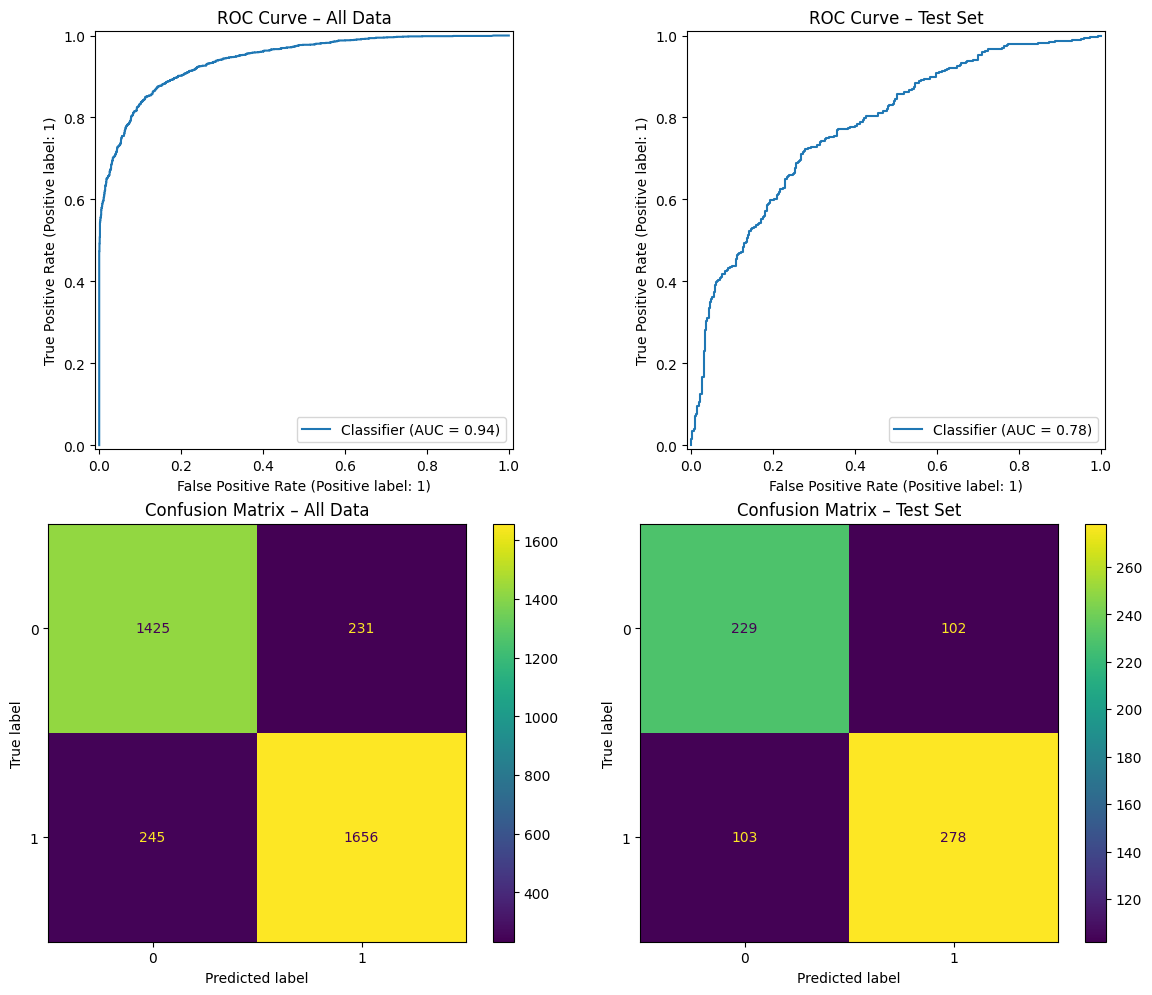

In [427]:
# Plot ROC curves and confusion matrices side-by-side
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ROC: Full Data
RocCurveDisplay.from_predictions(y, y_proba_full, ax=axes[0, 0])
axes[0, 0].set_title("ROC Curve – All Data")

# ROC: Test Set
RocCurveDisplay.from_predictions(y_test, y_proba_split, ax=axes[0, 1])
axes[0, 1].set_title("ROC Curve – Test Set")

# Confusion Matrix: Full Data
ConfusionMatrixDisplay.from_predictions(y, y_pred_full, ax=axes[1, 0])
axes[1, 0].set_title("Confusion Matrix – All Data")

# Confusion Matrix: Test Set
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_split, ax=axes[1, 1])
axes[1, 1].set_title("Confusion Matrix – Test Set")

plt.tight_layout()
plt.show()


**ROC Curve – All Data (Left)**
- The ROC curve is very close to the top-left corner, indicating excellent separability between classes.
- The area under the curve (AUC) is 0.94, suggesting very high overall classification performance.
- However, this curve reflects in-sample performance (i.e., evaluated on the same data the model was trained on).
- Consequently, it is likely over-optimistic, as it does not reflect how the model generalizes to unseen data.

**ROC Curve – Test Set (CV) (Right)**
- The curve is less steep and lies closer to the diagonal, especially in the middle region.
- The AUC here is 0.78, noticeably lower than the in-sample AUC, but still indicative of decent classification performance.
- This curve is based on unseen validation folds from outer cross-validation, providing a more reliable and unbiased estimate of the model's real-world generalization performance.
- The performance drop from 0.94 to 0.78 highlights a degree of overfitting on the training data.
- Nevertheless, the model is still able to discriminate between the two classes better than chance, which would yield an AUC of 0.50.

**Summary**
- The gap between the two curves reflects optimism bias present when evaluating on the training data.
- The outer cross-validation ROC confirms that, despite some overfitting, the final model maintains reasonable generalization capability.
- Reporting both curves is important to distinguish between model fit quality and actual predictive reliability.

**Confusion Matrix – All Data (Left)**
- The model correctly classifies 1425 true negatives and 1656 true positives.
- There are 231 false positives (class 0 incorrectly predicted as class 1) and 245 false negatives (class 1 incorrectly predicted as class 0).
- The distribution is relatively balanced, and performance appears strong across both classes.
- However, this result is derived from in-sample evaluation and is therefore likely over-optimistic.
- Since the model has seen the same data during training and evaluation, the low error rates may not generalize.

**Confusion Matrix – Test Set (CV) (Right)**
- On unseen validation data, the model correctly predicts 229 true negatives and 278 true positives.
- There are 102 false positives and 103 false negatives, indicating more misclassifications than in the full-data setting.
- The symmetry indicates that the model does not exhibit a strong bias toward overpredicting one class over the other.
- Balanced error rates suggest that the decision threshold and model structure treat both classes similarly, which is especially relevant when both types of errors are equally costly.
- This matrix provides a more realistic estimate of expected real-world performance.
- Overall, the model retains strong predictive ability, but with reduced accuracy and recall due to generalization limitations.

**Summary**
- The matrix on the full dataset shows very strong performance, with a high number of correctly classified instances and relatively few misclassifications. This reflects the model’s strong fit to the training data, but may overstate its true predictive ability.
- The matrix from cross-validation provides a more realistic estimate of performance by simulating how the model behaves on new, unseen data. It shows slightly reduced accuracy but retains strong predictive structure.
- Notably, the cross-validated matrix displays balanced error rates between false positives and false negatives. This suggests the model does not favor one class over the other, which is important for fair and robust classification, particularly when misclassifications in either direction are equally critical.
- Together, the two matrices support earlier findings from ROC and F1 metrics: while the model performs exceptionally on training data, its generalization remains solid and unbiased under real-world evaluation.




## Task 7 - Feature Importance / Ablation Study

### Feature Importance through Permutation

- Focused on understanding the relative contribution of each psychological predictor in the final Random Forest model.  
- Applied permutation-based feature importance, a model-agnostic technique that quantifies the performance drop (in F1 score) when the values of a single feature are randomly shuffled.  
- A greater drop indicates that the model relies more heavily on that feature to make accurate predictions.  
- This method is robust to multicollinearity and does not assume linearity or independence among features.  
- Provides interpretable, metric-specific insights into which variables drive the model's decisions.

**Implementation:**

- Feature importance was computed using the final Random Forest model trained on the full dataset (`final_rf_full`), without re-tuning.  
- Evaluations were performed on the same training data, since the goal was to assess internal feature reliance rather than generalization.  
- The permutation importance was based on the F1 score, aligning with the primary evaluation metric used throughout the project.  
- All nine psychological features were individually permuted, and the resulting performance drops were averaged to compute their relative importance.  
- Results were visualized in a horizontal boxplot to support interpretation and comparison.


In [428]:
test_result = permutation_importance(
    final_rf_full,
    X,
    y,
    n_repeats=30,
    random_state=42,
    scoring="f1",
    n_jobs=-1
)


In [429]:
# Create DataFrame of mean and std for each feature
perm_df = pd.DataFrame({
    "Feature": X.columns[sorted_idx],
    "Mean Importance (F1)": test_result.importances_mean[sorted_idx],
    "Std Dev": test_result.importances_std[sorted_idx]
})

# Sort descending by mean importance
perm_df = perm_df.sort_values(by="Mean Importance (F1)", ascending=False).reset_index(drop=True)

# Display rounded table
display(perm_df.round(4))

,Feature,Mean Importance (F1),Std Dev
0,envid,0.0837,0.0041
1,extmotiv,0.0757,0.0041
2,scicons,0.0675,0.0028
3,govtrust,0.0625,0.0031
4,ownestim,0.0559,0.0026
5,trustsci,0.0543,0.0021
6,globalid,0.0530,0.0039
7,humanid,0.0494,0.0024
8,intmotiv,0.0466,0.0031


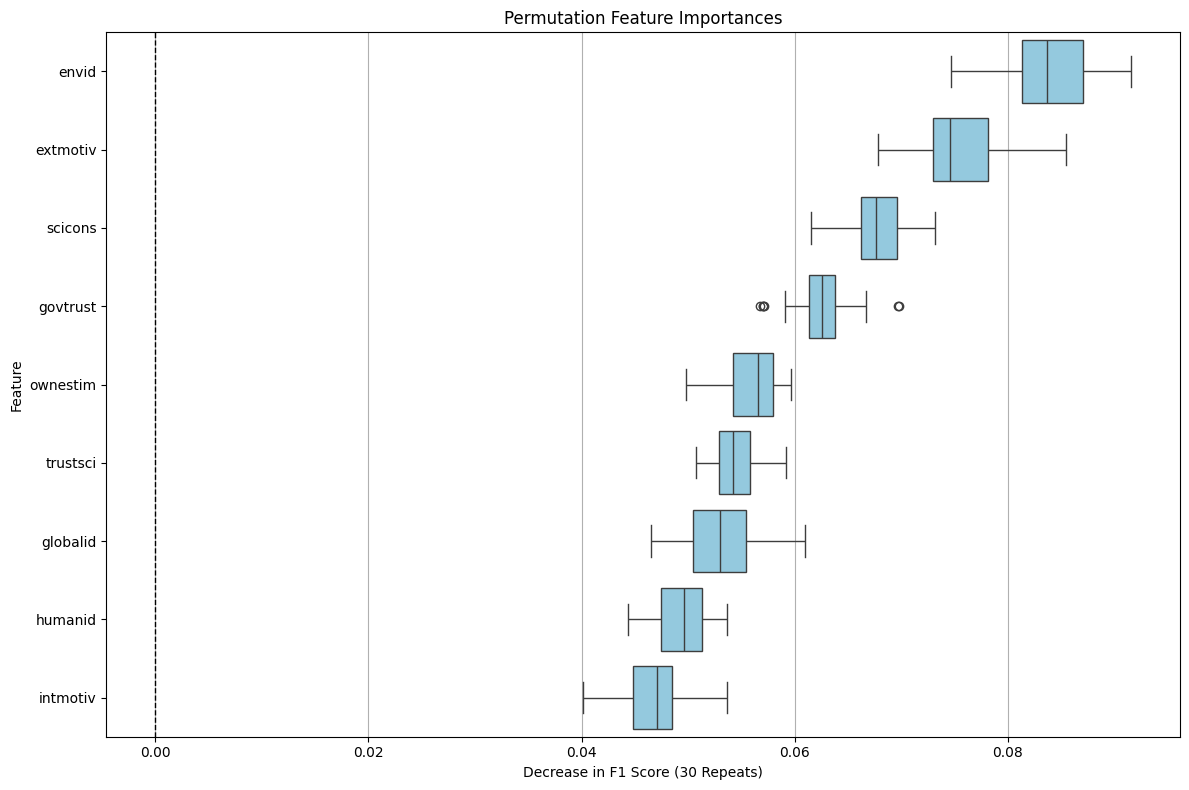

In [436]:
# Sort features by mean importance (descending)
sorted_idx = test_result.importances_mean.argsort()[::-1]
sorted_features = X.columns[sorted_idx]

# Create DataFrame of importances
test_importances = pd.DataFrame(
    test_result.importances[sorted_idx].T,
    columns=sorted_features
)

# Plot as horizontal boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=test_importances,
    orient="h",
    color="skyblue" 
)
plt.axvline(x=0, color="black", linestyle="--", linewidth=1)
plt.title("Permutation Feature Importances")
plt.xlabel("Decrease in F1 Score (30 Repeats)")
plt.ylabel("Feature")
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()


**Interpretation:**

- The boxplot and table summarize the permutation-based feature importance of each psychological variable in the final Random Forest model, measured by the mean decrease in F1 score across 30 permutations.
- `envid` (environmental identity) is the most important feature, indicating that the model’s ability to distinguish sharers from non-sharers relies most heavily on this variable.
- `extmotiv` (extrinsic motivation) ranks second, reinforcing the role of externally driven climate engagement (e.g., reputation, rewards) in predicting content sharing.
- Other features such as `scicons` (scientific consensus perception), `govtrust` (trust in government), and `ownestim` (perceived personal impact) also contribute meaningfully to the model’s predictions.
- `trustsci`, `globalid`, and `humanid` show moderate importance, suggesting they support but do not dominate classification decisions.
- `intmotiv` (intrinsic motivation) ranks lowest, although it still has a small positive importance. 
- The narrow standard deviations across all features suggest stable estimates, reinforcing the reliability of the observed ranking.
- While permutation importance provided useful insights into the relative influence of psychological features, it is sensitive to feature correlation. Highly correlated variabless may mask each other’s importance or artificially inflate their rankings. This makes it difficult to assess each predictor’s unique contribution.
- Overall, the model highlights environmental identity and extrinsic motivation as the key psychological levers in predicting willingness to share climate content. 
- These findings can inform targeted communication strategies, for instance by tailoring messages to individuals with strong environmental self-concept or by leveraging extrinsic motivators such as social approval or recognition.

### Ablation Study

- Evaluation how robust the final Random Forest model is to the removal of specific psychological predictors.
- This is done through ablation analysis: systematically excluding one or more features and comparing the resulting model performance to the full model.
- The purpose is to assess the practical necessity of certain variables and to better understand which predictors the model depends on.

**Implementation:**

- Four versions of the model were tested:
  - The full model using all predictors.
  - A model excluding `humanid` (human identity).
  - A model excluding `intmotiv` (intrinsic motivation).
  - A model excluding both `humanid` and `intmotiv`.
- A custom function `run_ablation_cv()` was developed to automate the evaluation of feature ablation scenarios.
- Each model variant is evaluated using the same nested cross-validation setup as in Task 6, ensuring comparability of F1 score and ROC AUC metrics.
- A custom pipeline component (`FeatureDropper`) is used to exclude selected features by name, integrated cleanly into the scikit-learn pipeline.
- The function treats each ablation (e.g., excluding `humanid`, `intmotiv`, or both) as a distinct experimental condition.
- This design allows precise measurement of how each feature affects performance when removed entirely from model training.
- This analysis complements the permutation-based feature importance from Task 7 by testing the effect of excluding predictors during model training, rather than permuting them during evaluation.


In [431]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    """
    Custom transformer to drop specified features by name.
    """
    def __init__(self, features_to_drop=None):
        self.features_to_drop = features_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.features_to_drop is None:
            return X
        return X.drop(columns=self.features_to_drop)


- adapted from: https://stackoverflow.com/questions/68402691/adding-dropping-column-instance-into-a-pipeline

In [432]:
def run_ablation_cv(model, X, y, features_to_drop=None, name="Ablation", scale=False):
    """
    Evaluates a classifier using outer cross-validation while 
    optionally dropping one or more features from the dataset.

    Parameters:
    - model (sklearn estimator): The trained classifier to use (e.g. RandomForestClassifier with best hyperparameters)
    - X (pd.DataFrame): Feature matrix including all original features
    - y (pd.Series): Target variable
    - features_to_drop (list of str or None): List of feature names to drop during preprocessing. If None, all features are used.
    - name (str): Label used to track this ablation experiment in result tables.
    - scale (bool): Whether to apply StandardScaler to the input data.

    Returns:
    - dict: A dictionary containing:
        - 'Setup': name of the ablation run
        - 'F1 Score': mean F1 score across all CV trials
        - 'ROC AUC': mean ROC AUC across all CV trials
        - 'Fit Time (s)': average training time per trial
    """
    f1_scores = []
    roc_auc_scores = []
    fit_times = []

    for trial in range(NUM_TRIALS):
        outer_cv = StratifiedKFold(n_splits=NUM_OUTER_SPLITS, shuffle=True, random_state=trial)

        pipeline = Pipeline([
            ("dropper", FeatureDropper(features_to_drop=features_to_drop)),
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler() if scale else FunctionTransformer()),
            ("estimator", model)
        ])

        scores = cross_validate(
            pipeline,
            X, y,
            scoring={"f1": "f1", "roc_auc": "roc_auc"},
            cv=outer_cv,
            return_train_score=False,
            n_jobs=-1
        )

        f1_scores.append(scores["test_f1"].mean())
        roc_auc_scores.append(scores["test_roc_auc"].mean())
        fit_times.append(scores["fit_time"].mean())

    return {
        "Setup": name,
        "F1 Score": np.mean(f1_scores),
        "ROC AUC": np.mean(roc_auc_scores),
        "Fit Time (s)": np.mean(fit_times)
    }


In [433]:
# Run all 4 ablation variants using your final model (rf)
results_ablation = []

# 1. Full model (all features)
results_ablation.append(
    run_ablation_cv(
        model=final_rf_best,
        X=X,
        y=y,
        features_to_drop=None,
        name="Full model (all features)",
        scale=False
    )
)

# 2. Drop humanid
results_ablation.append(
    run_ablation_cv(
        model=final_rf_best,
        X=X,
        y=y,
        features_to_drop=["humanid"],
        name="Ablation: -humanid",
        scale=False
    )
)

# 3. Drop intmotiv
results_ablation.append(
    run_ablation_cv(
        model=final_rf_best,
        X=X,
        y=y,
        features_to_drop=["intmotiv"],
        name="Ablation: -intmotiv",
        scale=False
    )
)

# 4. Drop both
results_ablation.append(
    run_ablation_cv(
        model=final_rf_best,
        X=X,
        y=y,
        features_to_drop=["humanid", "intmotiv"],
        name="Ablation: -humanid -intmotiv",
        scale=False
    )
)

df_ablation = pd.DataFrame(results_ablation)

display(df_ablation)


,Setup,F1 Score,ROC AUC,Fit Time (s)
0,Full model (all features),0.719494,0.766062,0.747729
1,Ablation: -humanid,0.720476,0.767708,0.751504
2,Ablation: -intmotiv,0.719787,0.764827,0.734436
3,Ablation: -humanid -intmotiv,0.720968,0.765281,0.745257


- All ablation variants achieve nearly identical F1 scores and ROC AUC values compared to the full model, with only negligible differences in both metrics.
- Performance slightly improves in some cases despite the removal of features, particularly when dropping both `humanid` and `intmotiv` together.
- This indicates that these features may contribute minimal or even noisy signal to the model, consistent with their low permutation importance observed in Task 7.
- The fit times remain nearly identical across all conditions, suggesting that the computational cost is unaffected by excluding one or two features.
- Overall, the results suggest that the final model is robust and not reliant on the presence of `humanid` or `intmotiv` for effective prediction. 
- Their removal may even slightly enhance model generalizability by reducing overfitting to uninformative patterns.

## Task 8

### Summary

- The final model, a Random Forest classifier with `n_estimators = 150`, `max_depth = 10`, `min_samples_split = 2`, `criterion = "entropy"`, and `max_features = 1`, was selected based on extensive nested cross-validation and grid search using F1 score as the optimization criterion.
- The model achieved a mean F1 score of approximately 0.719 and a mean ROC AUC of 0.766, averaged across 10 trials with 10-fold outer CV, confirming strong and consistent classification performance.
    - The classification performance of the final model can be considered strong given the psychological nature of the predictors and the exclusion of demographic or contextual variables.
    - While performance is not perfect, it is stable, generalizes well across folds, and outperforms all baselines, making it highly usable for real-world targeting in climate communication.
- The selected hyperparameters were derived from the top-performing configuration in a repeated 5-fold inner cross-validation with 3 repeats, which showed stable and robust results across multiple grid combinations.
- Learning curves showed that training F1 scores approached 0.89–1.00, while validation F1 scores stabilized around 0.71–0.73, indicating mild but controlled overfitting that does not worsen with additional data.
- Validation curves demonstrated that increasing the number of trees improves performance only up to a point (around 100–150 trees), and that deeper trees (beyond depth = 10) do not yield better generalization.
- ROC curves and confusion matrices indicated strong class separation and balanced detection of both sharers and non-sharers.
- Feature permutation results revealed that `envid` (environmental identity) and `extmotiv` (external motivation) were the most influential predictors, consistently reducing model performance when permuted.
- Features like `humanid` (humanitarian identity) and `intmotiv` (internal motivation) showed negligible or even negative importance, suggesting they may introduce noise or redundant signal.
- Ablation analysis confirmed these findings: removing `humanid`, `intmotiv`, or both did not reduce F1 or ROC AUC and in some cases slightly improved them, supporting the model’s robustness to irrelevant features.


### Generated Value

- The project was conducted in collaboration with an international NGO aiming to improve climate communication through data-driven targeting of online campaigns.
- The model identifies individuals who are psychologically predisposed to share climate-related posts, enabling the organization to prioritize outreach toward those most likely to amplify key messages.
- Social media acts as a multiplier in public climate discourse. Targeting high-sharing individuals increases peer-to-peer diffusion, thereby enhancing the visibility and perceived credibility of climate content.
- From a monetary perspective, the model improves campaign efficiency by reducing resource waste: communication budgets can be directed at high-impact individuals, minimizing spend on low-response segments.
- The model reveals that environmental identity and extrinsic motivation are strong predictors of climate-sharing behavior. This offers actionable insights for campaign design:
  - Messages can be framed to resonate with individuals’ environmental self-concept (e.g., appeals to identity, self-consistency, or personal meaning).
  - Interventions can emphasize extrinsic drivers such as public recognition, community engagement, or social norms to activate motivation.
- By focusing only on psychological variables, the model supports generalizable and equitable targeting across countries and cultures, avoiding biased assumptions based on age, gender, or income.
- The model contributes social value by advancing understanding of individual-level drivers of digital climate engagement, offering a scientific basis for behavioral change strategies.
- It empowers the NGO to shift from blanket messaging to tailored communication that leverages psychological traits, increasing both reach and resonance of climate information.
- Beyond classification, the model serves as a diagnostic tool: feature importance and ablation results help identify which psychological constructs are effective levers for behavioral intervention.
- The overall approach demonstrates how machine learning can support mission-driven, low-cost, high-impact communication strategies in the fight against climate change.

### Future Work

The following directions are proposed for future work to build on the current project and address key limitations:

- Apply gradient boosting methods such as XGBoost or LightGBM, which may outperform Random Forests in this context due to their ability to model non-linear interactions between psychological traits (e.g., environmental identity × motivation) and their built-in mechanisms for handling mild class imbalance and controlling overfitting through learning rate and regularization.
- Investigate model calibration techniques such as Platt scaling or isotonic regression to improve the reliability of predicted probabilities. Well-calibrated outputs are especially valuable for prioritizing high-confidence predictions in resource-constrained outreach campaigns.
- Augment the dataset with behavioral outcome variables such as observed content-sharing behavior from digital trace data. This would allow moving beyond self-reported intention to assess real-world predictive performance and enhance ecological validity.
- Conduct intervention studies aimed at strengthening key psychological traits identified as predictive, such as environmental identity and extrinsic motivation. These traits may be causally modifiable through targeted communication strategies, and experimental manipulation could validate their role in increasing climate engagement.
- Reframe feature evaluation in terms of practical modifiability. Even predictors with low statistical importance (e.g., humanid, intmotiv) may be strong candidates for educational interventions if they are psychologically plastic or responsive to persuasive messaging.
- While permutation importance and ablation were sufficient for this analysis, future work could incorporate SHAP values or partial dependence plots to provide finer-grained explanations of how specific features influence predicted probabilities. This would enhance transparency, especially if the model were to be deployed in public-facing or policy contexts.
- A known limitation of Random Forests is their limited interpretability compared to simpler models such as logistic regression or decision trees. While individual trees are interpretable, the ensemble nature of Random Forests makes it difficult to directly trace decision paths or understand specific predictions. To mitigate this, permutation-based feature importance and ablation studies were employed to provide insights into feature relevance and model behavior. Nonetheless, the overall model remains a black box to non-technical stakeholders. Future iterations could explore simpler, inherently interpretable models if transparency and explainability are prioritized over predictive performance.
- Examine interaction effects more systematically. While the current model prioritized main effects, exploring combinations such as identity × motivation may reveal psychologically meaningful subgroups and improve tailored communication strategies.
- Explore regional heterogeneity in predictor importance by modeling subsets of the data stratified by country or cultural cluster. Prior research suggests that the relevance of psychological traits may vary by sociopolitical context, which could inform culturally sensitive interventions.
- Test longitudinal extensions using panel data or repeated measures of psychological traits and behavior. This would allow tracking changes in predictors and engagement over time, as well as evaluating model stability in response to climate events or policy shifts.
- Address sampling limitations by re-training or evaluating the model on representative or stratified subsamples, especially from underrepresented countries. This would support fairness-aware modeling and assess how generalizable the model is across different population segments.

### Reflection

- The applied methodology followed best practices in supervised machine learning, including proper pipeline encapsulation, repeated and nested cross-validation, hyperparameter tuning, and permutation-based feature interpretation. This ensured methodological rigor, reproducibility, and minimized the risk of overfitting or data leakage.

- The project goal (predicting climate-sharing behavior from psychological variables) was ambitious but realistic. The use of self-reported survey data limited predictive performance but enabled a controlled and interpretable analysis of individual-level predictors. A key strength of the approach was the deliberate exclusion of demographic and structural variables. This maintained a clean focus on psychological traits, ensuring that any predictive power stemmed from modifiable constructs rather than immutable attributes such as age or nationality.

- However, relying exclusively on self-reported intention as the target variable is a notable limitation. Actual behavior may diverge due to situational constraints or social desirability effects, which likely contributed to the moderate ROC AUC of 0.77 despite rigorous model optimization. In retrospect, I might have placed more emphasis on identifying or simulating behavioral outcomes during data preparation, as this would have brought the prediction task closer to real-world application.

- The feature space, while psychologically rich, may also suffer from redundancy. Correlations among predictors (e.g., between identity and motivation) may obscure their unique contributions. In hindsight, I could have explored dimensionality reduction techniques such as PCA or feature clustering to assess overlap and potentially improve efficiency. Similarly, no additional feature engineering was conducted beyond imputation and scaling. Given more time, I would have considered interaction terms or non-linear transformations—particularly for k-NN and linear models.

- One methodological trade-off was the absence of explicit regularization mechanisms such as L1/L2 penalties or post-pruning techniques like cost-complexity pruning (`ccp_alpha`). This parameter could have further constrained tree complexity but was excluded due to the already extensive runtime of the nested cross-validation setup. Instead, regularization was handled structurally through parameters such as `max_depth`, `min_samples_split`, and `max_features`, which effectively controlled model complexity. Given the small generalization gap in nested CV and stable learning curves, this trade-off appeared justified.

- Runtime was a practical challenge: nested cross-validation with grid search took several hours to complete. While appropriate for final evaluation, earlier experimentation could have been accelerated using randomized search or smaller grid ranges. If I were to repeat the process, I would also parallelize outer CV loops more aggressively and introduce early-stopping strategies where possible.

- Another area for improvement lies in the definition of the application scenario. In hindsight, clarifying whether the model is meant for real-time targeting, stakeholder decision support, or academic insight would have helped align threshold optimization, evaluation metrics, and model selection more tightly with its intended use.

- Finally, while the model achieved meaningful predictive accuracy, incorporating behavioral context such as prior engagement with climate media or communication channels might have improved generalizability without compromising the psychological focus. These data could have been collected through additional survey items or linked metadata.

- Any future deployment of this model in outreach or targeting campaigns should consider ethical implications. Predicting individuals' psychological traits and engagement potential raises privacy concerns and risks of unintended profiling. Transparent communication, consent, and fairness auditing should accompany any real-world use.

- Overall, the project delivered a high-performing, interpretable model built on theoretically grounded features. However, multiple decisions could have been better aligned with practical constraints, downstream use cases, and opportunities for deeper modeling innovation.